In [1]:
%%html
<style>
table {float: left}
</style>

# Semesterarbeit Machine Learning

## Dokumenteninformationen

| Titel <img width=200/>| Schweizer Gesundheitskosten: Ein Blick in die Zukunft |
|:------------	|:----------------------------------------------------	|
| Schule     	| Fernfachhochschule Schweiz                  	        |
| Studiengang 	| Certificate of Advanced Studies in Machine Learning 	|
| Kennung     	| DS-C-ML001.ML.ZH-Sa-1.PVA.HS22/23                   	|
| Semester    	| Herbstsemester 2022/23                              	| 
| Dozent    	| **Ilir Fetai**<br>ilir.fetai@ffhs.ch<br>             	| 
| Autor    	    | **Patrick Hirschi**<br>Geburtsdatum: 12.01.1990<br>Matrikelnummer: 10-179-026<br>Studierenden-ID: 200768<br>patrick-hirschi@gmx.ch<br>                               	| 

## Abstract

text text text

![Alt-Text](./img/Onepager_Semesterarbeit_CAS_Machine_Learning_Patrick_Hirschi.jpeg "Onepager Semesterarbeit")

## Ordnerstruktur & Hinweise

## Datenbeschaffung
### Bundesamt für Statistik

#### Online-Datenbank STAT-TAB
Das Bundesamt für Statistik führt eine statistische Online-Datenbank (STAT-TAB) für den öffentlichen Zugriff auf Daten der amtlichen Statistik. Die Applikation wurde auf Basis der kostenlosen Software PX-WEB 2017 entwickelt entwickelt. Im Hintergrund sind die Daten in multidimensionalen Cubes abgelegt, was viele Filter-/Slicingmöglichkeiten bietet beim Abfragen der Daten. Ebenso existiert eine REST API, mit welcher man einen programmatischen und automatisierten Zugriff auf die Datensets umsetzen kann. Detaillierte Beschreibungen zu den einzelnen Datencubes und den Abfragemöglichkeiten findet man im [Leitfaden für Online-Datenrecherche (STAT-TAB)](https://dam-api.bfs.admin.ch/hub/api/dam/assets/270926/master "Leitfaden für Online-Datenrecherche (STAT-TAB)").

#### Asset-Datenbank 

Das Bundesamt für Statistik führt auch noch eine "Asset and Dissemination" Datenbank. Daten die nihct über die oben beschriebene STAT-TAB Datenbank/API bezogen werden können (z.B. weil sie nicht Teil der multidimensionalen Cubes sind) kann man so beziehen. Eine detaillierte Beschreibung findet man in der [BFS DAM-API Swagger Dokumentation](https://dam-api.bfs.admin.ch/hub/swagger-ui/index.html "BFS DAM-API Swagger Dokumentation").

#### Nutzungsbedingungen

Sehr wichtig ist, dass die Nutzungsbedingungen der Datensets beachtet werden. Es gibt verschiedene Kategorien:
  * **OPEN** (offen für alle Zwecke, Quellenangabe empfohlen)
  * **OPEN BY** (offen für alle Zwecke, Quellenangabe verpflichtend)
  * **OPEN ASK** (nicht-kommerziell OK, kommerziell muss erfragt werden beim Datenlieferanten, Quellenangabe empfohlen)
  * **OPEN BY ASK** (nicht-kommerziell OK, kommerziell muss erfragt werden beim Datenlieferanten, Quellenangabe verpflichtend)
  
Sämtliche für dieses Projekt verwendeten Datensets sind in der Kategorie **OPEN BY ASK**. Da es sich bei dieser studentischen Arbeit um einen nicht-kommerziellen Zweck handelt, reicht es also die Quelle der Daten anzugeben, und die Nutzung muss nicht noch separat beim Datenlieferanten erfragt werden. Die URLs für das Laden der Daten beschreiben die genutzten Ressourcen eindeutig.

### Modulimport

In [129]:
# import required modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import datetime
import requests
import pandas as pd
import numpy as np
import webbrowser
#!{sys.executable} -m pip install openpyxl

from requests.exceptions import HTTPError
from pandas_profiling import ProfileReport
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

print(f'The module import was successful!')

The module import was successful!


### Quelldaten laden

#### Konfiguration

In [3]:
# switch to True for reloading data or switch to False if wanting to skip 
# the reload and work with the existing data
download_new_source_data = False
# assign directory
directory = './data'
# get current datetime
datetime_now = datetime.datetime.now()

#### Laden der Daten über STAT-TAB pxweb-Ressourcen

In [4]:
# datetime method for logging purposes
def get_current_time_str():
    return datetime.datetime.now().strftime("%H:%M:%S.%f")

# data source URLs
data_sources = {
    # alt: 'Gesundheitskosten': 'https://www.pxweb.bfs.admin.ch/sq/7d87e7d5-bc25-489a-898a-ddd98b8cbb6d',
    'Gesundheitskosten': 'https://www.pxweb.bfs.admin.ch/sq/ddc67e6e-b175-42fe-9119-7b35abfd972e',
    'Demographie': 'https://www.pxweb.bfs.admin.ch/sq/b1f9ac16-47f4-4e1e-84a5-33b63a632a8d',
    'Bevölkerungsentwicklung': 'https://www.pxweb.bfs.admin.ch/sq/380ccae0-6b03-464d-90d4-8158b789838a',
    'GesundheitskostenFinanzierung': 'https://www.pxweb.bfs.admin.ch/sq/48e475cd-85e8-41c5-b2db-224937367885',
    'Konsumentenpreise': 'https://dam-api.bfs.admin.ch/hub/api/dam/assets/23664208/master'
}
# target filenames
target_filenames = {
    'Gesundheitskosten': 'gesundheitskosten_2010_bis_2020.csv',
    'Demographie': 'bevoelkerung_1981_bis_2021.csv',
    'Bevölkerungsentwicklung': 'szenarien_bevoelkerung_2019_bis_2070.csv',
    'GesundheitskostenFinanzierung': 'gesundheitskosten_finanzierung_1960_bis_2020.csv',
    'Konsumentenpreise': 'konsumentenpreise_1982_bis_2020.xlsx'
}

# only execute this code if the switch "download_new_source_data" is set to true
if download_new_source_data:
    # iterate over old data files in the directory and archive in ./data/archive folder
    for file in os.listdir(directory):
        # join the filepath information
        fullpath = os.path.join(directory, file)
        # split the filepath into filename and fileextension
        filename = os.path.splitext(file)[0]
        fileextension = os.path.splitext(file)[1]
        # generate a datestring to add to the archived filename
        datestring = datetime_now.strftime("%Y%m%d%H%M%S") + '_'
        # checking if it is a CSV/XLSX file to avoid archiving non-data files
        if os.path.isfile(fullpath) and (fullpath.endswith('.csv') or fullpath.endswith('.xlsx')):
            print(f'{get_current_time_str()}: Found file with path: {fullpath}')
            # generate archive filename
            newpath = directory + '/archive/' + datestring + filename + fileextension
            print(f'{get_current_time_str()}: Archive filepath will be: {newpath}')
            # rename the file and move it directly to the archive directory
            os.rename(fullpath,newpath)
            print(f'{get_current_time_str()}: Successfully archived file {fullpath}'
                  f' to {newpath}!') 
            
    # download latest data files from the Federal Office for Statistics of Switzerland (BfS)
    for key, url in data_sources.items():
        try:
            # access the data file url
            response = requests.get(url, allow_redirects=True)          
            # write content to the target file
            open(os.path.join(directory, target_filenames[key]), 'wb').write(response.content)          
            # get file stats
            file_stats = os.stat(os.path.join(directory, target_filenames[key]))
            # If the response was successful, no Exception will be raised
            response.raise_for_status()
        except HTTPError as http_err:
            # log the details of the HTTP exception (specific catch)
            print(f'{get_current_time_str()}: HTTP error occurred while' 
                  f'downloading data file {key} from {url}: {err}') 
        except Exception as err:
            # log the details of any other exception (generic catch)
            print(f'{get_current_time_str()}: Other error occurred while'
                  f'downloading data file {key} from {url}: {err}')  
        else:
            # download and file write was succesful
            print(f'{get_current_time_str()}: Successfully loaded '
                  f'{file_stats.st_size} bytes from {url} into the data file {target_filenames[key]}!') 
else:
    # source data was intentionally not re-loaded
    print(f'{get_current_time_str()}: '
          f'No data was reloaded from source! If this was not intended, change the switch '
          f'download_new_source_data to True.') 

15:23:15.501990: No data was reloaded from source! If this was not intended, change the switch download_new_source_data to True.


## Datenaufbereitung
### Profiling
#### Konfiguration

In [5]:
# set this to True if the data needs to be (re-)profiled
profile_data = True
# set the datestring for the profiling operations
profiling_datestring = datetime_now.strftime("%Y%m%d%H%M%S")

#### Datenset 1: Gesundheitskosten nach Leistung, Geschlecht und Altersklasse
Zu dem Datenset gibt es die folgenden Zusatzinformationen vom Bundesamt für Statistik ([Quelle: STAT-TAB Datencube Beschreibung](https://www.pxweb.bfs.admin.ch/pxweb/de/px-x-1405000000_103/-/px-x-1405000000_103.px/ "Quelle: STAT-TAB Datencube Beschreibung")).

**Kontakt:**
   * Sektion Gesundheitsversorgung, 058 463 67 00, E-Mail: gesundheit@bfs.admin.ch 

**Einheit:**
   * Million Franken; Franken 

**Metainformation:**
   * Letzte Änderungen: neuer Cube
   * Stand der Datenbank: 31.3.2022
   * Erhebungsperiode: Kalenderjahr
   * Raumbezug: Schweiz
   * Datenquelle: Kosten und Finanzierung des Gesundheitswesens (COU)

**Bemerkungen:**
   * Provisorische Daten für 2020 
   
##### Import der Daten
Die Daten sind von der Quelle nicht UTF-8 codiert. Aufgrund der speziellen Sonderzeichen der deutschen und französischen Sprache wurde latin-1 gewählt. Der Import funktioniert dann problemlos.

In [6]:
df_raw_gk = pd.read_csv(os.path.join(directory, target_filenames['Gesundheitskosten']), 
                        header=0, sep=';', encoding='latin-1')
df_raw_gk

,Masseinheit,Leistung,Geschlecht,Altersklasse,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Absolutwert,Leistung - Total,Geschlecht - Total,Altersklasse - Total,62564.98,64242.69,66512.44,69118.03,71429.22,74384.64,77455.23,79643.01,80241.83,82471.86,83310.76
1,Absolutwert,Leistung - Total,Geschlecht - Total,0-5 Jahre,1058.29,1081.82,1142.63,1201.47,1233.52,1286.22,1350.12,1397.85,1420.24,1446.21,1459.25
2,Absolutwert,Leistung - Total,Geschlecht - Total,6-10 Jahre,741.94,763.72,791.50,833.56,868.77,901.73,958.47,979.50,984.54,1030.28,1005.60
3,Absolutwert,Leistung - Total,Geschlecht - Total,11-15 Jahre,1167.69,1176.46,1187.57,1230.13,1274.32,1318.08,1367.32,1306.37,1257.24,1369.17,1574.17
4,Absolutwert,Leistung - Total,Geschlecht - Total,16-20 Jahre,1954.38,1966.64,2005.31,2032.15,2120.42,2215.10,2307.30,2400.91,2424.67,2481.64,2612.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,Wert pro Kopf und Monat,Verwaltung,Frau,76-80 Jahre,75.69,76.76,72.29,69.66,69.47,69.23,72.09,71.80,71.95,72.92,74.65
1130,Wert pro Kopf und Monat,Verwaltung,Frau,81-85 Jahre,95.00,95.89,90.38,85.32,85.33,85.59,88.57,88.10,89.04,90.43,92.66
1131,Wert pro Kopf und Monat,Verwaltung,Frau,86-90 Jahre,123.04,125.73,117.60,110.56,109.59,108.81,111.12,111.39,112.46,114.52,119.10
1132,Wert pro Kopf und Monat,Verwaltung,Frau,91-95 Jahre,164.99,167.50,154.12,147.86,143.82,144.08,143.55,142.55,143.94,146.25,157.40


##### Profiling des Dataframes mit dem pandas-profiling Package

In [7]:
# only profile the data file if profiling is configured (check switch "profile_data")
if profile_data:
    
    # set filepath (for new profiling report) and archive filepath (for old profiling report)
    print(f'{get_current_time_str()}: Generating filenames...') 
    fullpath = directory + '/profiles/' + target_filenames['Gesundheitskosten'] + '.html'
    archivepath = directory + '/profiles/archive/' + profiling_datestring + '_' +  \
                    target_filenames['Gesundheitskosten'] + '.html'
    print(f'{get_current_time_str()}: Filepath: {fullpath}') 
    print(f'{get_current_time_str()}: Archive Filepath: {archivepath}') 
    
    # archive old profile reports
    if os.path.isfile(fullpath):
        # rename the file and move it directly to the archive directory
        os.rename(fullpath,archivepath)
        print(f'{get_current_time_str()}: Successfully archived file {fullpath}'
                  f' to {archivepath}!') 
        
    # generate profile report
    print(f'{get_current_time_str()}: Generating profiling report...') 
    report = ProfileReport(df_raw_gk)
    print(f'{get_current_time_str()}: Successfully generated profiling report!') 
    
    # dump the report to a HTML file (jupyter inline rendering breaks the github quickview)
    print(f'{get_current_time_str()}: Dumping profiling report to file...') 
    report.to_file(fullpath)
    print(f'{get_current_time_str()}: Successfully dumped profiling report to file {fullpath}!') 
    
    # open the HTML file in a new browser tab
    print(f'{get_current_time_str()}: Trying to open HTML profiling report {fullpath}'
                  f' in a new browser tab...')
    # bash command to open HTML file because IPython is only called server-side 
    # and tab-opening does not work
    !open {fullpath}

15:23:15.526758: Generating filenames...
15:23:15.526936: Filepath: ./data/profiles/gesundheitskosten_2010_bis_2020.csv.html
15:23:15.526945: Archive Filepath: ./data/profiles/archive/20221224152315_gesundheitskosten_2010_bis_2020.csv.html
15:23:15.527440: Successfully archived file ./data/profiles/gesundheitskosten_2010_bis_2020.csv.html to ./data/profiles/archive/20221224152315_gesundheitskosten_2010_bis_2020.csv.html!
15:23:15.527449: Generating profiling report...
15:23:15.529274: Successfully generated profiling report!
15:23:15.529285: Dumping profiling report to file...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

15:23:25.813177: Successfully dumped profiling report to file ./data/profiles/gesundheitskosten_2010_bis_2020.csv.html!
15:23:25.813202: Trying to open HTML profiling report ./data/profiles/gesundheitskosten_2010_bis_2020.csv.html in a new browser tab...


##### Erkenntnisse
Der Profiling Report gibt eine schöne Übersicht über die Daten im Dataframe. Daraus lassen sich einige Erkenntnisse ziehen:
   * Keine Zeilen-Duplikate
   * Keine Missing Values
   * 4 kategoriale und 11 numerische Variablen (15 insgesamt)
   * 378 Beobachtungen/Zeilen
   * Altersklasse in 5 Jahres Bins (0-5, 6-10, etc.)
   * Unter den 21 Alerts werden einige Korrelationen gemeldet zwischen den Gesundheitskosten der einzelnen Jahre, aber keine Alerts die eine immediate Korrektur-/Bereinigungsaktion erfordern würden.

Der Report zeigt, dass das Datenset strukturell und inhaltlich sauber aussieht. Transformationen werden erst nötig, wenn dieses Datenset mit den anderen Datensets zusammen ausgewertet werden soll.

#### Datenset 2: Demografische Bilanz nach Alter und Kanton
Zu dem Datenset gibt es die folgenden Zusatzinformationen vom Bundesamt für Statistik ([Quelle: STAT-TAB Datencube Beschreibung](https://www.pxweb.bfs.admin.ch/pxweb/de/px-x-0102020000_104/-/px-x-0102020000_104.px/ "Quelle: STAT-TAB Datencube Beschreibung")).

**Kontakt:**
   * Sektion Demografie und Migration, +41 58 463 67 11, E-Mail: info.dem@bfs.admin.ch

**Einheit:**
   * Person; Ereignis  

**Metainformation:**
   * Letzte Änderungen: Neuer Datensatz (2021)
   * Stand der Datenbank: August 2022
   * Erhebungsperiode: 1. Januar - 31. Dezember
   * Raumbezug: Kantone / 01.01.1997
   * Datenquelle: 1981-2010 Statistik des jährlichen Bevölkerungsstandes (ESPOP), ab 2011 Statistik der Bevölkerung und der Haushalte (STATPOP)

Die demografische Bilanz zeigt die Veränderung des Bevölkerungsbestandes aufgrund von natürlichen (Geburten, Todesfälle) und räumlichen (Ein- und Auswanderung bzw. interkantonale Zu- und Wegzüge) Bevölkerungsbewegungen sowie allfälligen statistischen Korrekturen.    
ESPOP war eine Synthesestatistik, die auf der Statistik der natürlichen Bevölkerungsbewegung (BEVNAT), der Statistik der ausländischen Wohnbevölkerung (PETRA) sowie der Wanderungsstatistik der schweizerischen Wohnbevölkerung basierte. Zudem stützte sie sich auf die Eidgenössischen Volkszählungen (VZ) von 1990 und 2000. ESPOP verwendete die Methode der Bevölkerungsfortschreibung. Dabei wird der Bevölkerungsstand per 31. Dezember eines bestimmten Kalenderjahres ermittelt, indem zum Bestand per 31. Dezember des Vorjahres die Geburten und die Zuwanderungen des jeweiligen Kalenderjahres addiert und die Todesfälle und die Abwanderungen subtrahiert werden. 
STATPOP entnimmt Bestandes- und Bewegungsdaten aus den Personenregistern des Bundes sowie den harmonisierten Einwohnerregistern der Gemeinden und Kantone und beruht somit auf einem anderen Produktionsverfahren als ESPOP. 
Die Bevölkerungsbestände per 31. Dezember eines Kalenderjahres und per 1. Januar des folgenden Kalenderjahres sind in folgenden Fällen nicht identisch: (1) Anpassung der Bestandesdaten an die VZ (1990/91 bzw. 2000/01); (2) Umstellung von ESPOP auf STATPOP (2010/11); (3) Gebietsstandänderungen auf Ebene Kanton (1993/94 bzw. 1995/96).
Wegen der Umstellung von ESPOP auf STATPOP entspricht zudem die Zahl der Todesfälle 2010 nicht deren offizieller Zahl gemäss BEVNAT.    
Die Bezugsbevölkerung der demografischen Bilanz ist die «ständige Wohnbevölkerung», zu der bis 2010 alle schweizerischen Staatsangehörigen mit einem Hauptwohnsitz in der Schweiz, sowie alle ausländischen Staatsangehörigen mit einer Anwesenheitsbewilligung für mindestens 12 Monate gehören. Mit der Einführung von STATPOP wurde die Bezugsbevölkerung neu definiert. Im Vergleich zu früher umfasst sie seit dem 1.1.2011 zusätzlich Personen im Asylprozess mit einer Gesamtaufenthaltsdauer von mindestens 12 Monaten. 

**Bemerkungen:**
   * keine relevanten
   
##### Import der Daten
Die Daten sind von der Quelle nicht UTF-8 codiert. Aufgrund der speziellen Sonderzeichen der deutschen und französischen Sprache wurde latin-1 gewählt. Der Import funktioniert dann problemlos.

In [8]:
df_raw_dg = pd.read_csv(os.path.join(directory, target_filenames['Demographie']), 
                        header=0, sep=';', encoding='latin-1')
df_raw_dg

,Jahr,Kanton,Staatsangehörigkeit (Kategorie),Geschlecht,Alter,Bestand am 31. Dezember
0,1981,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Mann,Alter - Total,3101817
1,1981,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Mann,0 Jahre,37618
2,1981,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Mann,1 Jahr,37352
3,1981,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Mann,2 Jahre,36363
4,1981,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Mann,3 Jahre,36175
...,...,...,...,...,...,...
8277,2021,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Frau,95 Jahre,4453
8278,2021,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Frau,96 Jahre,3277
8279,2021,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Frau,97 Jahre,2484
8280,2021,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Frau,98 Jahre,1665


In [9]:
# only profile the data file if profiling is configured (check switch "profile_data")
if profile_data:
    
    # set filepath (for new profiling report) and archive filepath (for old profiling report)
    print(f'{get_current_time_str()}: Generating filenames...') 
    fullpath = directory + '/profiles/' + target_filenames['Demographie'] + '.html'
    archivepath = directory + '/profiles/archive/' + profiling_datestring + '_' +  \
                    target_filenames['Demographie'] + '.html'
    print(f'{get_current_time_str()}: Filepath: {fullpath}') 
    print(f'{get_current_time_str()}: Archive Filepath: {archivepath}') 
    
    # archive old profile reports
    if os.path.isfile(fullpath):
        # rename the file and move it directly to the archive directory
        os.rename(fullpath,archivepath)
        print(f'{get_current_time_str()}: Successfully archived file {fullpath}'
                  f' to {archivepath}!') 
        
    # generate profile report
    print(f'{get_current_time_str()}: Generating profiling report...') 
    report = ProfileReport(df_raw_dg)
    print(f'{get_current_time_str()}: Successfully generated profiling report!') 
    
    # dump the report to a HTML file (jupyter inline rendering breaks the github quickview)
    print(f'{get_current_time_str()}: Dumping profiling report to file...') 
    report.to_file(fullpath)
    print(f'{get_current_time_str()}: Successfully dumped profiling report to file {fullpath}!') 
    
    # open the HTML file in a new browser tab
    print(f'{get_current_time_str()}: Trying to open HTML profiling report {fullpath}'
                  f' in a new browser tab...')
    # bash command to open HTML file because IPython is only called server-side 
    # and tab-opening does not work
    !open {fullpath}

15:23:26.018058: Generating filenames...
15:23:26.018213: Filepath: ./data/profiles/bevoelkerung_1981_bis_2021.csv.html
15:23:26.018223: Archive Filepath: ./data/profiles/archive/20221224152315_bevoelkerung_1981_bis_2021.csv.html
15:23:26.018571: Successfully archived file ./data/profiles/bevoelkerung_1981_bis_2021.csv.html to ./data/profiles/archive/20221224152315_bevoelkerung_1981_bis_2021.csv.html!
15:23:26.018589: Generating profiling report...
15:23:26.021926: Successfully generated profiling report!
15:23:26.021938: Dumping profiling report to file...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

15:23:27.337661: Successfully dumped profiling report to file ./data/profiles/bevoelkerung_1981_bis_2021.csv.html!
15:23:27.337684: Trying to open HTML profiling report ./data/profiles/bevoelkerung_1981_bis_2021.csv.html in a new browser tab...


##### Erkenntnisse
Der Profiling Report zeigt folgende Erkenntnisse:
   * Keine Zeilen-Duplikate
   * Keine Missing Values
   * 4 kategoriale und 2 numerische Variablen (6 insgesamt)
   * 8'282 Beobachtungen/Zeilen
   * Geschlecht und Alter sind uniform verteilt
   * Unter den 10 Alerts:
       - Spalte "Kanton" mit konstantem Wert "Schweiz" (Massnahme: Spalte löschen)
       - Spalte "Staatsangehörigkeit (Kategorie)" mit konstantem Wert "Staatsangehörigkeit (Kategorie) - Total" (Massnahme: Spalte umbenennen und Wert ändern/kürzen auf "Total")
       - Spalte "Alter" hat 101 verschiedene Wert, 0-99 und mehr Jahre, und einer für "Alter - Total" (Massnahme: Alter zusammenfassen zu Altersklassen in 5 Jahres Bins - 0-5, 6-10, etc.)

#### Datenset 3: Szenarien zur Bevölkerungsentwicklung der Schweiz 2020-2070 - Bevölkerung und Bewegungen nach Szenario-Variante, Staatsangehörigkeit (Kategorie), Geschlecht, Altersklasse, Jahr und Beobachtungseinheit
Zu dem Datenset gibt es die folgenden Zusatzinformationen vom Bundesamt für Statistik ([Quelle: STAT-TAB Datencube Beschreibung](https://www.pxweb.bfs.admin.ch/pxweb/de/px-x-0104000000_102/-/px-x-0104000000_102.px/table/tableViewLayout2/ "Quelle: STAT-TAB Datencube Beschreibung")). Ebenso gibt es eine Beschreibung der getroffenen Annahmen ([Quelle: Bundesamt für Statistik](https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/zukuenftige-entwicklung/schweiz-szenarien.html "Quelle: Bundesamt für Statistik")).

**Kontakt:**
   * Sektion Demografie und Migration, +41 58 463 67 11, E-Mail: info.dem@bfs.admin.ch

**Einheit:**
   * Person  

**Metainformation:**
   * Letzte Änderungen: neuer Datensatz (2019-2070)
   * Stand der Datenbank: Mai 2020
   * Erhebungsstichtag / Erhebungsperiode: 31. Dezember / 2019-2070
   * Raumbezug: Schweiz und Kantone / 01.01.1997
   * Datenquelle: SZENARIEN Bevölkerungsszenarien
   * Detaillierte Informationen: über die Szenarien zur Bevölkerungsentwicklung der Schweiz
   

**Bemerkungen:**
   * keine relevanten
   
##### Import der Daten
Die Daten sind von der Quelle nicht UTF-8 codiert. Aufgrund der speziellen Sonderzeichen der deutschen und französischen Sprache wurde latin-1 gewählt. Der Import funktioniert dann problemlos.

In [10]:
df_raw_be = pd.read_csv(os.path.join(directory, target_filenames['Bevölkerungsentwicklung']), 
                        header=0, sep=';', encoding='latin-1')

In [11]:
# only profile the data file if profiling is configured (check switch "profile_data")
if profile_data:
    
    # set filepath (for new profiling report) and archive filepath (for old profiling report)
    print(f'{get_current_time_str()}: Generating filenames...') 
    fullpath = directory + '/profiles/' + target_filenames['Bevölkerungsentwicklung'] + '.html'
    archivepath = directory + '/profiles/archive/' + profiling_datestring + '_' +  \
                    target_filenames['Bevölkerungsentwicklung'] + '.html'
    print(f'{get_current_time_str()}: Filepath: {fullpath}') 
    print(f'{get_current_time_str()}: Archive Filepath: {archivepath}') 
    
    # archive old profile reports
    if os.path.isfile(fullpath):
        # rename the file and move it directly to the archive directory
        os.rename(fullpath,archivepath)
        print(f'{get_current_time_str()}: Successfully archived file {fullpath}'
                  f' to {archivepath}!') 
        
    # generate profile report
    print(f'{get_current_time_str()}: Generating profiling report...') 
    report = ProfileReport(df_raw_be)
    print(f'{get_current_time_str()}: Successfully generated profiling report!') 
    
    # dump the report to a HTML file (jupyter inline rendering breaks the github quickview)
    print(f'{get_current_time_str()}: Dumping profiling report to file...') 
    report.to_file(fullpath)
    print(f'{get_current_time_str()}: Successfully dumped profiling report to file {fullpath}!') 
    
    # open the HTML file in a new browser tab
    print(f'{get_current_time_str()}: Trying to open HTML profiling report {fullpath}'
                  f' in a new browser tab...')
    # bash command to open HTML file because IPython is only called server-side 
    # and tab-opening does not work
    !open {fullpath}

15:23:27.667031: Generating filenames...
15:23:27.667181: Filepath: ./data/profiles/szenarien_bevoelkerung_2019_bis_2070.csv.html
15:23:27.667196: Archive Filepath: ./data/profiles/archive/20221224152315_szenarien_bevoelkerung_2019_bis_2070.csv.html
15:23:27.667660: Successfully archived file ./data/profiles/szenarien_bevoelkerung_2019_bis_2070.csv.html to ./data/profiles/archive/20221224152315_szenarien_bevoelkerung_2019_bis_2070.csv.html!
15:23:27.667672: Generating profiling report...
15:23:27.670131: Successfully generated profiling report!
15:23:27.670140: Dumping profiling report to file...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

15:23:30.765776: Successfully dumped profiling report to file ./data/profiles/szenarien_bevoelkerung_2019_bis_2070.csv.html!
15:23:30.765800: Trying to open HTML profiling report ./data/profiles/szenarien_bevoelkerung_2019_bis_2070.csv.html in a new browser tab...


##### Erkenntnisse
Der Profiling Report zeigt folgende Erkenntnisse:
   * Keine Zeilen-Duplikate
   * Keine Missing Values
   * 4 kategoriale und 2 numerische Variablen (6 insgesamt)
   * 228'384 Beobachtungen/Zeilen
   * Geschlecht und Alter sind uniform verteilt
   * zwölf verschiedene Szenario Varianten (Massnahme: aufsplitten in einzelne Dataframes)
   * Unter den 11 Alerts:
       - Spalte "Staatsangehörigkeit (Kategorie)" mit konstantem Wert "Staatsangehörigkeit (Kategorie) - Total"(Massnahme: Spalte umbenennen und Wert ändern/kürzen auf "total")
       - Spalte "Alter" hat 122 verschiedene Werte, 0-120 und mehr Jahre, und einer für "Alter - Total" (Massnahme: Alter zusammenfassen zu Altersklassen in 5 Jahres Bins - 0-5, 6-10, etc.)
       - "Bevölkerungsstand am 31. Dezember" hat 22505 0-Werte (nicht fehlend, sondern 0). Wenn man sich diese genauer anschaut, macht es aber auch Sinn. Da die Altersskala bis 120 Jahre geht, ist es natürlich möglich, dass es in den Jahren > 100 teilweise 0 Personen gibt, die dieses Alter erreicht haben. Es werden hier also keine weiteren Massnahmen eingeleitet.

#### Datenset 4: LIK, Totalindex auf allen Indexbasen 1984-2020
Zu dem Datenset gibt es die folgenden Zusatzinformationen vom Bundesamt für Statistik ([BfS Katalog Datenbank](https://www.bfs.admin.ch/bfs/de/home/statistiken/kataloge-datenbanken/tabellen.assetdetail.23664208.html "Quelle: BfS Katalog Datenbank")).

**Kontakt:**
   * Bundesamt für Statistik, +41 58 463 60 11

**Einheit:**
   * Prozent 

**Metainformation:**
   * Stand der Datenbank:  	03.11.2022
   * Erhebungsperiode: 1.12.1982-31.10.2022
   * Datenquelle: Landesindex der Konsumentenpreise

**Bemerkungen:**
   * keine relevanten
   
##### Import der Daten

In [12]:
df_raw_kp = pd.read_excel(os.path.join(directory, target_filenames['Konsumentenpreise']), 'VAR_y-1', header=3)
df_raw_kp

,Code,PosNo,PosType,Level,COICOP,Position_D,PosTxt_D,Position_F,PosTxt_F,Posizione_I,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,100_100,100.0,1.0,1.0,NaN,Total,Total,Total,Total,Totale,...,-0.7,-0.2,0,-1.1,-0.4,0.5,0.9,0.4,-0.7,0.6
1,100_1,1.0,2.0,2.0,'01,Nahrungsmittel und alkoholfreie Getränke,Nahrungsmittel und alkoholfreie Getränke,Alimentation et boissons non alcoolisées,Alimentation et boissons non alcoolisées,Prodotti alimentari e bevande analcoliche,...,-1,1.2,0.9,-0.8,0.4,0.4,1.3,0.1,0.1,-1.6
2,100_1001,1001.0,3.0,3.0,'01.1,Nahrungsmittel,Nahrungsmittel,Alimentation,Alimentation,Prodotti alimentari,...,-1.1,1.4,1.1,-0.8,0.5,0.5,1.3,0.2,0.1,-1.6
3,100_1002,1002.0,3.0,4.0,'01.1.1,"Brot, Mehl und Getreideprodukte","Brot, Mehl und Getreideprodukte","Pain, farine et produits céréaliers","Pain, farine et produits céréaliers","Pane, farina e cereali",...,-1.3,-0.6,0.1,0.4,-0.1,-0.2,0.8,0,-0.8,-0.9
4,100_1003,1003.0,4.0,5.0,'01.1.1.1,Reis,Reis,Riz,Riz,Riso,...,-0.2,2.5,13.8,1,1.1,-1.2,-0.6,2.6,-0.6,-2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,1170_302,302.0,NaN,NaN,NaN,Kerninflation 2,Kerninflation 2,Inflation sous-jacente 2,Inflation sous-jacente 2,Zoccolo dell'inflazione 2,...,-1.3,-0.3,0.3,-0.6,-0.2,0.4,0.8,0.7,-0.1,0.4
477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478,"© Bundesamt für Statistik, Espace de l'Europe ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479,"Auskunft: LIK@bfs.admin.ch, 058 / 463 69 00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# only profile the data file if profiling is configured (check switch "profile_data")
if profile_data:
    
    # set filepath (for new profiling report) and archive filepath (for old profiling report)
    print(f'{get_current_time_str()}: Generating filenames...') 
    fullpath = directory + '/profiles/' + target_filenames['Konsumentenpreise'] + '.html'
    archivepath = directory + '/profiles/archive/' + profiling_datestring + '_' +  \
                    target_filenames['Konsumentenpreise'] + '.html'
    print(f'{get_current_time_str()}: Filepath: {fullpath}') 
    print(f'{get_current_time_str()}: Archive Filepath: {archivepath}') 
    
    # archive old profile reports
    if os.path.isfile(fullpath):
        # rename the file and move it directly to the archive directory
        os.rename(fullpath,archivepath)
        print(f'{get_current_time_str()}: Successfully archived file {fullpath}'
                  f' to {archivepath}!') 
        
    # generate profile report
    print(f'{get_current_time_str()}: Generating profiling report...') 
    report = ProfileReport(df_raw_kp)
    print(f'{get_current_time_str()}: Successfully generated profiling report!') 
    
    # dump the report to a HTML file (jupyter inline rendering breaks the github quickview)
    print(f'{get_current_time_str()}: Dumping profiling report to file...') 
    report.to_file(fullpath)
    print(f'{get_current_time_str()}: Successfully dumped profiling report to file {fullpath}!') 
    
    # open the HTML file in a new browser tab
    print(f'{get_current_time_str()}: Trying to open HTML profiling report {fullpath}'
                  f' in a new browser tab...')
    # bash command to open HTML file because IPython is only called server-side 
    # and tab-opening does not work
    !open {fullpath}

15:23:31.346417: Generating filenames...
15:23:31.346520: Filepath: ./data/profiles/konsumentenpreise_1982_bis_2020.xlsx.html
15:23:31.346527: Archive Filepath: ./data/profiles/archive/20221224152315_konsumentenpreise_1982_bis_2020.xlsx.html
15:23:31.346855: Successfully archived file ./data/profiles/konsumentenpreise_1982_bis_2020.xlsx.html to ./data/profiles/archive/20221224152315_konsumentenpreise_1982_bis_2020.xlsx.html!
15:23:31.346869: Generating profiling report...
15:23:31.351418: Successfully generated profiling report!
15:23:31.351430: Dumping profiling report to file...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

15:23:34.975088: Successfully dumped profiling report to file ./data/profiles/konsumentenpreise_1982_bis_2020.xlsx.html!
15:23:34.975109: Trying to open HTML profiling report ./data/profiles/konsumentenpreise_1982_bis_2020.xlsx.html in a new browser tab...


##### Erkenntnisse
Der Profiling Report zeigt folgende Erkenntnisse:
   * 2.9% (14) Zeilen-Duplikate
   * 7.8% (1'989) Missing Values
   * 39 nicht-supportete, 11 kategoriale und 3 numerische Variablen (53 insgesamt)
   * 481 Beobachtungen/Zeilen
   * Unter den 117 Alerts:
       - Etliche Inkonsistenzen, korrupte Spalten und ähnliches. Bevor hier Verbesserungen angebracht werden, soll allerdings entschieden werden, welche der Zeilen/Spalten überhaupt relevant sind für die Arbeit. Hier wird nur die totale jahresdurchschnittliche Teuerung sowie die Teuerung isoliert für die KAtegorie "Gesundheitspflege" verwendet.

#### Datenset 5: Kosten und Finanzierung des Gesundheitswesens nach Leistungserbringer, Leistung und Finanzierungsregime (1960-2020)
Zu dem Datenset gibt es die folgenden Zusatzinformationen vom Bundesamt für Statistik ([BfS Katalog Datenbank](https://www.bfs.admin.ch/bfs/de/home/statistiken/gesundheit/kosten-finanzierung.assetdetail.22324823.html "Quelle: BfS Katalog Datenbank")).

**Kontakt:**
   * Bundesamt für Statistik, +41 58 463 60 11

**Einheit:**
   * Million Franken  

**Metainformation:**
   * Stand der Datenbank:  	31.03.2022
   * Erhebungsperiode: Kalenderjahr
   * Datenquelle: Kosten und Finanzierung des Gesundheitswesens (COU) 

**Bemerkungen:**
   * Provisorische Daten für 2020 
   
##### Import der Daten

In [14]:
df_raw_kf = pd.read_csv(os.path.join(directory, target_filenames['GesundheitskostenFinanzierung']), 
                        header=0, sep=';', encoding='latin-1')
df_raw_kf

,Leistungserbringer,Leistung,Finanzierungsregime,1960,1961,1962,1963,1964,1965,1966,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Leistungserbringer - Total,Leistung - Total,Finanzierungsregime - Total,2007.69,2131.08,2312.56,2493.62,2757.68,3045.28,3554.01,...,64242.69,66512.43,69118.03,71429.22,74384.64,77455.21,79643.01,80241.80,82471.86,83310.76
1,Leistungserbringer - Total,>> L Stationäre Kurativbehandlung,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,13582.55,14176.31,14791.18,14947.37,15385.88,15758.00,15718.28,15547.74,15730.23,16223.16
2,Leistungserbringer - Total,>> M Ambulante Kurativbehandlung,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,16108.74,16924.49,17687.57,18680.79,19541.36,20436.38,21108.17,20753.48,21652.45,20177.76
3,Leistungserbringer - Total,>> N Rehabilitation,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,2788.52,2833.70,2925.49,3079.71,3378.04,3560.31,3662.72,3822.54,3886.68,3769.68
4,Leistungserbringer - Total,>> O Langzeitpflege,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,13256.77,13831.65,14255.11,14627.86,15129.31,15448.66,15942.85,16374.29,16769.35,17209.26
5,Leistungserbringer - Total,>> P Unterstützende Dienstleistungen,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,3716.59,3966.27,4414.05,4766.94,5037.25,5552.55,6028.43,6188.39,6675.70,6772.73
6,Leistungserbringer - Total,>> Q Gesundheitsgüter,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,10097.63,10181.46,10418.93,10604.07,11100.11,11702.09,12088.35,12213.71,12602.42,12693.54
7,Leistungserbringer - Total,>> R Prävention,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,1695.75,1699.66,1780.63,1852.44,1877.56,1894.01,1937.12,2126.11,1829.02,3017.50
8,Leistungserbringer - Total,>> S Verwaltung,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,2996.12,2898.90,2845.06,2870.06,2935.12,3103.20,3157.10,3215.55,3325.99,3447.12


In [15]:
# only profile the data file if profiling is configured (check switch "profile_data")
if profile_data:
    
    # set filepath (for new profiling report) and archive filepath (for old profiling report)
    print(f'{get_current_time_str()}: Generating filenames...') 
    fullpath = directory + '/profiles/' + target_filenames['GesundheitskostenFinanzierung'] + '.html'
    archivepath = directory + '/profiles/archive/' + profiling_datestring + '_' +  \
                    target_filenames['GesundheitskostenFinanzierung'] + '.html'
    print(f'{get_current_time_str()}: Filepath: {fullpath}') 
    print(f'{get_current_time_str()}: Archive Filepath: {archivepath}') 
    
    # archive old profile reports
    if os.path.isfile(fullpath):
        # rename the file and move it directly to the archive directory
        os.rename(fullpath,archivepath)
        print(f'{get_current_time_str()}: Successfully archived file {fullpath}'
                  f' to {archivepath}!') 
        
    # generate profile report
    print(f'{get_current_time_str()}: Generating profiling report...') 
    report = ProfileReport(df_raw_kf)
    print(f'{get_current_time_str()}: Successfully generated profiling report!') 
    
    # dump the report to a HTML file (jupyter inline rendering breaks the github quickview)
    print(f'{get_current_time_str()}: Dumping profiling report to file...') 
    report.to_file(fullpath)
    print(f'{get_current_time_str()}: Successfully dumped profiling report to file {fullpath}!') 
    
    # open the HTML file in a new browser tab
    print(f'{get_current_time_str()}: Trying to open HTML profiling report {fullpath}'
                  f' in a new browser tab...')
    # bash command to open HTML file because IPython is only called server-side 
    # and tab-opening does not work
    !open {fullpath}

15:23:35.188042: Generating filenames...
15:23:35.188172: Filepath: ./data/profiles/gesundheitskosten_finanzierung_1960_bis_2020.csv.html
15:23:35.188182: Archive Filepath: ./data/profiles/archive/20221224152315_gesundheitskosten_finanzierung_1960_bis_2020.csv.html
15:23:35.188432: Successfully archived file ./data/profiles/gesundheitskosten_finanzierung_1960_bis_2020.csv.html to ./data/profiles/archive/20221224152315_gesundheitskosten_finanzierung_1960_bis_2020.csv.html!
15:23:35.188442: Generating profiling report...
15:23:35.193293: Successfully generated profiling report!
15:23:35.193308: Dumping profiling report to file...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

15:24:12.959649: Successfully dumped profiling report to file ./data/profiles/gesundheitskosten_finanzierung_1960_bis_2020.csv.html!
15:24:12.959674: Trying to open HTML profiling report ./data/profiles/gesundheitskosten_finanzierung_1960_bis_2020.csv.html in a new browser tab...


##### Erkenntnisse
Der Profiling Report zeigt folgende Erkenntnisse:
   * 0.0% (0) Zeilen-Duplikate
   * 0.0% (0) Missing Values - dies ist allerdings ein Fehler. Im Datensatz sind offensichtlich fehlende Werte mit einem Stern gekennzeichnet. Dies muss bereinigt werden.
   * Spalte Finanzierungsregime ist obsolet (immer "Finanzierungsregime - Total")
   * Spalte Leistungserbringer ist obsolet (immer "Leistungserbringer - Total")
   * Spalte Leistung soll bereinigt werden (Entfernen der Präfixes wie z.B. ">> N")
   * 38 kategoriale und 26 numerische Variablen (64 insgesamt). Auch hier leidet die Statistik unter den Stern-Werten (Fehlende Werte).
   * 9 Beobachtungen/Zeilen
   * Unter den 92 Alerts:
       - Keine neuen Erkenntnisse.

### Bereinigung

#### Datenset 1: Gesundheitskosten nach Leistung, Geschlecht und Altersklasse 2010-2020

In [16]:
df_raw_gk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Masseinheit   1134 non-null   object 
 1   Leistung      1134 non-null   object 
 2   Geschlecht    1134 non-null   object 
 3   Altersklasse  1134 non-null   object 
 4   2010          1134 non-null   float64
 5   2011          1134 non-null   float64
 6   2012          1134 non-null   float64
 7   2013          1134 non-null   float64
 8   2014          1134 non-null   float64
 9   2015          1134 non-null   float64
 10  2016          1134 non-null   float64
 11  2017          1134 non-null   float64
 12  2018          1134 non-null   float64
 13  2019          1134 non-null   float64
 14  2020          1134 non-null   float64
dtypes: float64(11), object(4)
memory usage: 133.0+ KB


In [17]:
# copy the dataframe
df_raw_gk_clean = df_raw_gk.copy()

# for the time being no transformations are needed

# check the output after the transformations
df_raw_gk_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Masseinheit   1134 non-null   object 
 1   Leistung      1134 non-null   object 
 2   Geschlecht    1134 non-null   object 
 3   Altersklasse  1134 non-null   object 
 4   2010          1134 non-null   float64
 5   2011          1134 non-null   float64
 6   2012          1134 non-null   float64
 7   2013          1134 non-null   float64
 8   2014          1134 non-null   float64
 9   2015          1134 non-null   float64
 10  2016          1134 non-null   float64
 11  2017          1134 non-null   float64
 12  2018          1134 non-null   float64
 13  2019          1134 non-null   float64
 14  2020          1134 non-null   float64
dtypes: float64(11), object(4)
memory usage: 133.0+ KB


In [18]:
# copy the dataframe
df_raw_gk_clean_category = df_raw_gk_clean.copy()

# filter dataframe and exclude rows with values per capita and month
df_raw_gk_clean_category = df_raw_gk_clean_category.query("Masseinheit!='Wert pro Kopf und Monat'")
# filter dataframe and exclude rows with total per service
df_raw_gk_clean_category = df_raw_gk_clean_category.query("Leistung!='Leistung - Total'")
# filter dataframe and exclude rows with total for genders
df_raw_gk_clean_category = df_raw_gk_clean_category.query("Geschlecht!='Geschlecht - Total'")
# filter dataframe and exclude rows with total for agegroups
df_raw_gk_clean_category = df_raw_gk_clean_category.query("Altersklasse!='Altersklasse - Total'")

# replace strings in age groups with empty strings
df_raw_gk_clean_category['Altersklasse'] = df_raw_gk_clean_category['Altersklasse'] \
                                                .str.replace(' Jahre','')
df_raw_gk_clean_category['Altersklasse'] = df_raw_gk_clean_category['Altersklasse'] \
                                                .str.replace(' und mehr Jahre','+')
   
# change column datatype to category
df_raw_gk_clean_category['Altersklasse'] = df_raw_gk_clean_category['Altersklasse'].astype('category')
# rename column "Altersklasse" to "Altersgruppe"
df_raw_gk_clean_category.rename(columns = {'Altersklasse':'Altersgruppe'}, inplace = True)

# pivot and stack the table to have the years in a specific column
df_raw_gk_clean_category = pd.pivot_table(
    df_raw_gk_clean_category,
    values=['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020'],
    index=['Masseinheit','Leistung','Altersgruppe','Geschlecht']
    ).stack().reset_index()

# rename automatically created columns
df_raw_gk_clean_category.rename(columns = {'level_4':'Jahr', 0:'Kosten'}, inplace = True)

# group and sum over genders
df_raw_gk_clean_category = df_raw_gk_clean_category \
                                    .groupby(['Jahr','Masseinheit','Leistung','Altersgruppe'])['Kosten'] \
                                    .sum() \
                                    .reset_index()

# multiply all values in column "Kosten" by 1'000'000 since the unit is "million swiss francs"
df_raw_gk_clean_category['Kosten'] = df_raw_gk_clean_category['Kosten'] \
                                    .mul(1000000)

# drop unnecessary columns
df_raw_gk_clean_category.drop('Masseinheit', axis=1, inplace=True)

# change column type to int
df_raw_gk_clean_category['Jahr'] = df_raw_gk_clean_category['Jahr'] \
                                    .astype(int)

df_raw_gk_clean_category

,Jahr,Leistung,Altersgruppe,Kosten
0,2010,Ambulante Kurativbehandlung,0-5,405520000.0
1,2010,Ambulante Kurativbehandlung,11-15,461050000.0
2,2010,Ambulante Kurativbehandlung,16-20,797820000.0
3,2010,Ambulante Kurativbehandlung,21-25,684230000.0
4,2010,Ambulante Kurativbehandlung,26-30,806200000.0
...,...,...,...,...
1755,2020,Verwaltung,76-80,293100000.0
1756,2020,Verwaltung,81-85,240630000.0
1757,2020,Verwaltung,86-90,184740000.0
1758,2020,Verwaltung,91-95,96200000.0


#### Datenset 2: Demografische Bilanz nach Alter und Kanton 1981-2021

In [19]:
df_raw_dg

,Jahr,Kanton,Staatsangehörigkeit (Kategorie),Geschlecht,Alter,Bestand am 31. Dezember
0,1981,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Mann,Alter - Total,3101817
1,1981,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Mann,0 Jahre,37618
2,1981,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Mann,1 Jahr,37352
3,1981,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Mann,2 Jahre,36363
4,1981,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Mann,3 Jahre,36175
...,...,...,...,...,...,...
8277,2021,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Frau,95 Jahre,4453
8278,2021,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Frau,96 Jahre,3277
8279,2021,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Frau,97 Jahre,2484
8280,2021,Schweiz,Staatsangehörigkeit (Kategorie) - Total,Frau,98 Jahre,1665


In [20]:
# copy the dataframe
df_raw_dg_clean = df_raw_dg.copy()
# drop unnecessary columns
df_raw_dg_clean.drop('Kanton', axis=1, inplace=True)
df_raw_dg_clean.drop('Staatsangehörigkeit (Kategorie)', axis=1, inplace=True)

# filter dataframe and exclude rows with total count over all age(groups)
df_raw_dg_clean = df_raw_dg_clean.query("Alter!='Alter - Total'")
# remove all non-number characters in column "Alter"
df_raw_dg_clean = df_raw_dg_clean.assign(Alter = lambda x: x['Alter'].str.extract('(\d+)'))
# change column type to int
df_raw_dg_clean['Alter'] = df_raw_dg_clean['Alter'].astype('int')

# generate age groups of 5 years
bins= [0,6,11,16,21,26,31,36,41,46,51,56,61,66,71,76,81,86,91,96,np.inf]

labels = ['0-5','6-10','11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50',
          '51-55','56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96+']

df_raw_dg_clean['Altersgruppe'] = pd.cut(df_raw_dg_clean['Alter'], \
                                          bins=bins,  \
                                          labels=labels,  \
                                          right=False)
df_raw_dg_clean['Altersgruppe'] = df_raw_dg_clean['Altersgruppe'] \
                                    .cat \
                                    .add_categories('unbekannt') \
                                    .fillna('unbekannt')

# check the output after the transformations
df_raw_dg_clean

,Jahr,Geschlecht,Alter,Bestand am 31. Dezember,Altersgruppe
1,1981,Mann,0,37618,0-5
2,1981,Mann,1,37352,0-5
3,1981,Mann,2,36363,0-5
4,1981,Mann,3,36175,0-5
5,1981,Mann,4,36929,0-5
...,...,...,...,...,...
8277,2021,Frau,95,4453,91-95
8278,2021,Frau,96,3277,96+
8279,2021,Frau,97,2484,96+
8280,2021,Frau,98,1665,96+


In [21]:
df_raw_dg_clean_category = df_raw_dg_clean.copy()
df_raw_dg_clean_category = df_raw_dg_clean_category \
                                .groupby(['Jahr', 'Altersgruppe'])['Bestand am 31. Dezember'] \
                                .sum() \
                                .reset_index()
df_raw_dg_clean_category

,Jahr,Altersgruppe,Bestand am 31. Dezember
0,1981,0-5,431325
1,1981,6-10,400210
2,1981,11-15,480991
3,1981,16-20,514235
4,1981,21-25,473002
...,...,...,...
856,2021,81-85,215876
857,2021,86-90,133058
858,2021,91-95,54222
859,2021,96+,12846


#### Datenset 3: Szenarien zur Bevölkerungsentwicklung der Schweiz 2020-2070

In [22]:
df_raw_be

,Szenario-Variante,Staatsangehörigkeit (Kategorie),Geschlecht,Alter,Jahr,Bevölkerungsstand am 31. Dezember
0,Referenzszenario A-00-2020,Staatsangehörigkeit - Total,Geschlecht - Total,Alter - Total,2019,8615846
1,Referenzszenario A-00-2020,Staatsangehörigkeit - Total,Geschlecht - Total,Alter - Total,2020,8688215
2,Referenzszenario A-00-2020,Staatsangehörigkeit - Total,Geschlecht - Total,Alter - Total,2021,8761372
3,Referenzszenario A-00-2020,Staatsangehörigkeit - Total,Geschlecht - Total,Alter - Total,2022,8835055
4,Referenzszenario A-00-2020,Staatsangehörigkeit - Total,Geschlecht - Total,Alter - Total,2023,8909158
...,...,...,...,...,...,...
228379,Variante A-07-2020 'stabile Auswanderungsziffern',Staatsangehörigkeit - Total,Frau,120 Jahre,2066,0
228380,Variante A-07-2020 'stabile Auswanderungsziffern',Staatsangehörigkeit - Total,Frau,120 Jahre,2067,0
228381,Variante A-07-2020 'stabile Auswanderungsziffern',Staatsangehörigkeit - Total,Frau,120 Jahre,2068,0
228382,Variante A-07-2020 'stabile Auswanderungsziffern',Staatsangehörigkeit - Total,Frau,120 Jahre,2069,0


In [23]:
df_raw_be["Szenario-Variante"].unique()

array(['Referenzszenario A-00-2020', "'hohes' Szenario B-00-2020",
       "'tiefes' Szenario C-00-2020",
       "Szenario D-00-2020 'verstärkte Alterung'",
       "Szenario E-00-2020 'abgeschwächte Alterung'",
       "Variante A-01-2020 'höhere Fertilität'",
       "Variante A-02-2020 'niedrigere Fertilität'",
       "Variante A-03-2020 'höhere Lebenserwartung bei der Geburt'",
       "Variante A-04-2020 'niedrigere Lebenserwartung bei der Geburt'",
       "Variante A-05-2020 'hohes Wanderungssaldo'",
       "Variante A-06-2020 'tiefes Wanderungssaldo'",
       "Variante A-07-2020 'stabile Auswanderungsziffern'"], dtype=object)

In [24]:
# copy the dataframe
df_raw_be_clean = df_raw_be.copy()

scenarios_to_keep = \
[ \
 'Referenzszenario A-00-2020', \
 '\'hohes\' Szenario B-00-2020', \
 '\'tiefes\' Szenario C-00-2020', \
 'Szenario D-00-2020 \'verstärkte Alterung\'', \
# 'Szenario E-00-2020 \'abgeschwächte Alterung\'', \
# 'Variante A-01-2020 \'höhere Fertilität\'', \
# 'Variante A-02-2020 \'niedrigere Fertilität\'', \
 'Variante A-03-2020 \'höhere Lebenserwartung bei der Geburt\'' \
# 'Variante A-04-2020 \'niedrigere Lebenserwartung bei der Geburt\'', \
# 'Variante A-05-2020 \'hohes Wanderungssaldo\'', \
# 'Variante A-06-2020 \'tiefes Wanderungssaldo\'', \
# 'Variante A-07-2020 \'stabile Auswanderungsziffern\'' \
]

# filter dataframe for specific scenarios only (configured just above)
df_raw_be_clean = df_raw_be_clean[df_raw_be_clean["Szenario-Variante"] \
                        .isin(scenarios_to_keep)]

# drop unnecessary columns
df_raw_be_clean.drop('Staatsangehörigkeit (Kategorie)', axis=1, inplace=True)

# check the output after the transformations
df_raw_be_clean

,Szenario-Variante,Geschlecht,Alter,Jahr,Bevölkerungsstand am 31. Dezember
0,Referenzszenario A-00-2020,Geschlecht - Total,Alter - Total,2019,8615846
1,Referenzszenario A-00-2020,Geschlecht - Total,Alter - Total,2020,8688215
2,Referenzszenario A-00-2020,Geschlecht - Total,Alter - Total,2021,8761372
3,Referenzszenario A-00-2020,Geschlecht - Total,Alter - Total,2022,8835055
4,Referenzszenario A-00-2020,Geschlecht - Total,Alter - Total,2023,8909158
...,...,...,...,...,...
152251,Variante A-03-2020 'höhere Lebenserwartung bei...,Frau,120 Jahre,2066,0
152252,Variante A-03-2020 'höhere Lebenserwartung bei...,Frau,120 Jahre,2067,0
152253,Variante A-03-2020 'höhere Lebenserwartung bei...,Frau,120 Jahre,2068,0
152254,Variante A-03-2020 'höhere Lebenserwartung bei...,Frau,120 Jahre,2069,0


#### Datenset 4: Konsumentenpreise: Jahresdurchschnittliche Teuerung 1984-2021

In [25]:
df_raw_kp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 53 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Code         463 non-null    object 
 1   PosNo        456 non-null    float64
 2   PosType      429 non-null    float64
 3   Level        429 non-null    float64
 4   COICOP       295 non-null    object 
 5   Position_D   456 non-null    object 
 6   PosTxt_D     456 non-null    object 
 7   Position_F   456 non-null    object 
 8   PosTxt_F     456 non-null    object 
 9   Posizione_I  456 non-null    object 
 10  PosTxt_I     456 non-null    object 
 11  Item_E       456 non-null    object 
 12  PosTxt_E     456 non-null    object 
 13  2022         456 non-null    float64
 14  1983         0 non-null      float64
 15  1984         456 non-null    object 
 16  1985         456 non-null    object 
 17  1986         456 non-null    object 
 18  1987         456 non-null    object 
 19  1988    

In [26]:
# copy the dataframe
df_raw_kp_clean = df_raw_kp.copy()

# convert all column names to strings and strip whitespace
df_raw_kp_clean = df_raw_kp_clean.rename(columns=lambda x: str(str(x).strip()))

# filter dataframe for row with total inflation (Code 100_100) and inflation 
# for healthcare products (Code 100_6)
df_raw_kp_clean = df_raw_kp_clean.query("(Code=='100_100') or (Code=='100_6')").reset_index()

# rename category column
df_raw_kp_clean.rename(columns={ "Position_D": "Kategorie" }, inplace = True)
# drop unnecessary columns
df_raw_kp_clean = df_raw_kp_clean[['Kategorie','1983', '1984', '1985', '1986', '1987', '1988', 
                                   '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', 
                                   '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', 
                                   '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', 
                                   '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', 
                                   '2021']]

# drop duplicates
df_raw_kp_clean.drop_duplicates(keep='first', inplace=True)

# drop NaN column
df_raw_kp_clean.drop('1983', axis=1, inplace=True)

# change all columns except "Kategorie" to float data type
df_raw_kp_clean.iloc[:,1:] = df_raw_kp_clean.iloc[:,1:].astype(float)

# pivot and stack the table to have the years in a specific column
df_raw_kp_clean = pd.pivot_table(
    df_raw_kp_clean,
    values=df_raw_kp_clean.iloc[:,1:],
    index=['Kategorie']
    ).stack().reset_index()

# rename automatically created columns
df_raw_kp_clean.rename(columns = {'level_1':'Jahr', 0:'LIK'}, inplace = True)

# print the result
df_raw_kp_clean

,Kategorie,Jahr,LIK
0,Gesundheitspflege,1984,3.2
1,Gesundheitspflege,1985,4.0
2,Gesundheitspflege,1986,2.2
3,Gesundheitspflege,1987,2.7
4,Gesundheitspflege,1988,3.6
...,...,...,...
71,Total,2017,0.5
72,Total,2018,0.9
73,Total,2019,0.4
74,Total,2020,-0.7


Datenset 4 ist somit fertig bereinigt.

#### Datenset 5: Kosten und Finanzierung des Gesundheitswesens nach Leistungserbringer, Leistung und Finanzierungsregime (1960-2020)

In [27]:
df_raw_kf

,Leistungserbringer,Leistung,Finanzierungsregime,1960,1961,1962,1963,1964,1965,1966,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Leistungserbringer - Total,Leistung - Total,Finanzierungsregime - Total,2007.69,2131.08,2312.56,2493.62,2757.68,3045.28,3554.01,...,64242.69,66512.43,69118.03,71429.22,74384.64,77455.21,79643.01,80241.80,82471.86,83310.76
1,Leistungserbringer - Total,>> L Stationäre Kurativbehandlung,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,13582.55,14176.31,14791.18,14947.37,15385.88,15758.00,15718.28,15547.74,15730.23,16223.16
2,Leistungserbringer - Total,>> M Ambulante Kurativbehandlung,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,16108.74,16924.49,17687.57,18680.79,19541.36,20436.38,21108.17,20753.48,21652.45,20177.76
3,Leistungserbringer - Total,>> N Rehabilitation,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,2788.52,2833.70,2925.49,3079.71,3378.04,3560.31,3662.72,3822.54,3886.68,3769.68
4,Leistungserbringer - Total,>> O Langzeitpflege,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,13256.77,13831.65,14255.11,14627.86,15129.31,15448.66,15942.85,16374.29,16769.35,17209.26
5,Leistungserbringer - Total,>> P Unterstützende Dienstleistungen,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,3716.59,3966.27,4414.05,4766.94,5037.25,5552.55,6028.43,6188.39,6675.70,6772.73
6,Leistungserbringer - Total,>> Q Gesundheitsgüter,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,10097.63,10181.46,10418.93,10604.07,11100.11,11702.09,12088.35,12213.71,12602.42,12693.54
7,Leistungserbringer - Total,>> R Prävention,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,1695.75,1699.66,1780.63,1852.44,1877.56,1894.01,1937.12,2126.11,1829.02,3017.50
8,Leistungserbringer - Total,>> S Verwaltung,Finanzierungsregime - Total,*,*,*,*,*,*,*,...,2996.12,2898.90,2845.06,2870.06,2935.12,3103.20,3157.10,3215.55,3325.99,3447.12


In [28]:
# copy the dataframe
df_raw_kf_clean = df_raw_kf.copy()
# drop unnecessary columns
df_raw_kf_clean.drop('Leistungserbringer', axis=1, inplace=True)
df_raw_kf_clean.drop('Finanzierungsregime', axis=1, inplace=True)
# filter out total values
# df_raw_kf_clean = df_raw_kf_clean.query("Leistung!='Leistung - Total'")

# clean values in column "Leistung"
df_raw_kf_clean['Leistung'] = df_raw_kf_clean['Leistung'] \
                                .replace(['Leistung - Total'], \
                                         'LeistungenTotal')
df_raw_kf_clean['Leistung'] = df_raw_kf_clean['Leistung'] \
                                .replace(['>> L Stationäre Kurativbehandlung'], \
                                         'Stationäre Kurativbehandlung')
df_raw_kf_clean['Leistung'] = df_raw_kf_clean['Leistung'] \
                                .replace(['>> M Ambulante Kurativbehandlung'], \
                                         'Ambulante Kurativbehandlung')
df_raw_kf_clean['Leistung'] = df_raw_kf_clean['Leistung'] \
                                .replace(['>> N Rehabilitation'], \
                                          'Rehabilitation')
df_raw_kf_clean['Leistung'] = df_raw_kf_clean['Leistung'] \
                                .replace(['>> O Langzeitpflege'], \
                                          'Langzeitpflege')
df_raw_kf_clean['Leistung'] = df_raw_kf_clean['Leistung'] \
                                .replace(['>> P Unterstützende Dienstleistungen'], \
                                          'Unterstützende Dienstleistungen')
df_raw_kf_clean['Leistung'] = df_raw_kf_clean['Leistung'] \
                                .replace(['>> Q Gesundheitsgüter'], \
                                          'Gesundheitsgüter')
df_raw_kf_clean['Leistung'] = df_raw_kf_clean['Leistung'] \
                                .replace(['>> R Prävention'], \
                                          'Prävention')
df_raw_kf_clean['Leistung'] = df_raw_kf_clean['Leistung'] \
                                .replace(['>> S Verwaltung'], \
                                          'Verwaltung')
# clean *-values to nan
df_raw_kf_clean = df_raw_kf_clean.replace(['*'], np.nan)

# change all columns except "Leistung" to float data type
df_raw_kf_clean.iloc[:,1:] = df_raw_kf_clean.iloc[:,1:].astype(float)

# multiply all values by 1'000'000 since the unit is "million swiss francs"
df_raw_kf_clean.iloc[:,1:] = df_raw_kf_clean.iloc[:,1:].mul(1000000)

# pivot and stack the table to have the years in a specific column
df_raw_kf_clean = pd.pivot_table(
    df_raw_kf_clean,
    values=df_raw_kf_clean.iloc[:,1:],
    index=['Leistung']
    ).stack().reset_index()

# rename automatically created columns
df_raw_kf_clean.rename(columns = {'level_1':'Jahr', 0:'Kosten'}, inplace = True)

# change column type to int
df_raw_kf_clean['Jahr'] = df_raw_kf_clean['Jahr'].astype(int)

# check the output after the transformations
df_raw_kf_clean

,Leistung,Jahr,Kosten
0,Ambulante Kurativbehandlung,1995,8.336030e+09
1,Ambulante Kurativbehandlung,1996,8.662070e+09
2,Ambulante Kurativbehandlung,1997,8.865660e+09
3,Ambulante Kurativbehandlung,1998,9.409030e+09
4,Ambulante Kurativbehandlung,1999,9.774160e+09
...,...,...,...
264,Verwaltung,2016,3.103200e+09
265,Verwaltung,2017,3.157100e+09
266,Verwaltung,2018,3.215550e+09
267,Verwaltung,2019,3.325990e+09


Datenset 5 ist somit fertig bereinigt.

### Sanity Checks

#### Kosten pro Jahr und Leistung zwischen 2010 und 2020 (Datenset 1 & 5)

In [29]:
# group and sum dataset 1 over year and service and compare to other dataset
df_raw_gk_clean_category_sanity_check = df_raw_gk_clean_category.copy()
df_raw_gk_clean_category_sanity_check = df_raw_gk_clean_category_sanity_check \
                                            .groupby(['Jahr','Leistung'])['Kosten'] \
                                            .sum() \
                                            .reset_index()
df_raw_gk_clean_category_sanity_check = df_raw_gk_clean_category_sanity_check \
                                            .query("(Jahr>=2010) and (Jahr<=2020)") \
                                            .reset_index(drop=True)

# remove entries from 1995 to 2010 from dataset 5
df_raw_kf_clean_sanity_check = df_raw_kf_clean.copy()
df_raw_kf_clean_sanity_check = df_raw_kf_clean_sanity_check \
                                            .query("(Jahr>=2010) and (Jahr<=2020)") \
                                            .reset_index(drop=True)

# reindex dataframes to be able to compare
columns_titles = ["Jahr","Leistung","Kosten"]
df_raw_kf_clean_sanity_check.sort_values(by=["Jahr","Leistung"], ascending=False)
df_raw_gk_clean_category_sanity_check.sort_values(by=["Jahr","Leistung"], ascending=False)
df_raw_kf_clean_sanity_check = df_raw_kf_clean_sanity_check \
                                            .reindex(columns=columns_titles)
df_raw_gk_clean_category_sanity_check = df_raw_gk_clean_category_sanity_check \
                                            .reindex(columns=columns_titles)

# compare the datasets
merged = pd.merge(df_raw_kf_clean_sanity_check, df_raw_gk_clean_category_sanity_check, 
                  on=['Jahr','Leistung'], how='inner')
merged

,Jahr,Leistung,Kosten_x,Kosten_y
0,2010,Ambulante Kurativbehandlung,1.580831e+10,1.580830e+10
1,2011,Ambulante Kurativbehandlung,1.610874e+10,1.610875e+10
2,2012,Ambulante Kurativbehandlung,1.692449e+10,1.692450e+10
3,2013,Ambulante Kurativbehandlung,1.768757e+10,1.768757e+10
4,2014,Ambulante Kurativbehandlung,1.868079e+10,1.868076e+10
...,...,...,...,...
83,2016,Verwaltung,3.103200e+09,3.103180e+09
84,2017,Verwaltung,3.157100e+09,3.157110e+09
85,2018,Verwaltung,3.215550e+09,3.215540e+09
86,2019,Verwaltung,3.325990e+09,3.325990e+09


Die Differenzen sind auf die Rundung bei Datenset 1 pro Altersgruppe zurückzuführen. Bei Datenset 5 sind es von Anfang an aggregierte Werte über alle Altersguppen und die Zahl ist somit genauer. Da für dieses Vorhaben aber die Zahlen pro Altersgruppe relevant sind, und keine genauere/komplettere Quelle gefunden wurde, gibt es keine Wahl. Für einen ersten Vorhersageversuch, soll aber mit den totalen Kosten pro Leistung über alle Altersgruppen gearbeitet werden. Eventuell sind dadurch bereits gute Resultate zu erzielen.
Falls nicht, kann in einem zweiten Versuch noch die Aufteilung auf die Altersklassen miteinbezogen werden.

#### Demografische Bilanz (Datenset 2)
Die Bevölkerungsszenarien (Datenset 3) starten im Jahr 2019 und Datenset 2 reicht bis 2021. Somit können wenigstens die Zahlen für 2019, 2020 und 2021 noch kurz geprüft werden.

In [30]:
# dataset 2: group over year and sum the people count
df_raw_dg_clean_category_sanity_check = df_raw_dg_clean_category.copy()
df_raw_dg_clean_category_sanity_check = df_raw_dg_clean_category_sanity_check \
                                    .groupby(['Jahr'])['Bestand am 31. Dezember'] \
                                    .sum() \
                                    .reset_index()
df_raw_dg_clean_category_sanity_check = df_raw_dg_clean_category_sanity_check \
                                    .query("(Jahr>=2019) and (Jahr<=2021)") \
                                    .reset_index(drop=True)

# dataset 3: group over year and sum the people count
df_raw_be_clean_sanity_check = df_raw_be_clean.copy()
df_raw_be_clean_sanity_check.rename(columns={"Bevölkerungsstand am 31. Dezember":  \
                                             "Bestand am 31. Dezember" }, inplace = True)
df_raw_be_clean_sanity_check = df_raw_be_clean_sanity_check \
                                    .query("(`Szenario-Variante`=='Referenzszenario A-00-2020') and \
                                            (Jahr >= 2019) and \
                                            (Jahr <= 2021) and \
                                            (Alter!='Alter - Total') and \
                                            (Geschlecht!='Geschlecht - Total')") \
                                    .reset_index(drop=True)
df_raw_be_clean_sanity_check = df_raw_be_clean_sanity_check \
                                    .groupby(['Jahr'])['Bestand am 31. Dezember'] \
                                    .sum() \
                                    .reset_index()

# compare the datasets
merged = pd.merge(df_raw_be_clean_sanity_check, df_raw_dg_clean_category_sanity_check, 
                  on=['Jahr'], how='inner')
merged

,Jahr,Bestand am 31. Dezember_x,Bestand am 31. Dezember_y
0,2019,8615846,8606033
1,2020,8688215,8670300
2,2021,8761372,8738791


Wenig überraschend gibt es schon in den ersten drei Jahren der vorhergesagten Referenzszenarien leichte Abweichungen zu den effektiv gemessenen Werten. Die Abweichungen bewegen sich zwischen 9'000 und 23'000 Personen, was einem Fehler von 0.26% im Jahr 2021 entspricht. Die folgende Grafik zeigt grafisch die Entwicklung für die drei Referenzszenarien ([Quelle: Bundesamt für Statistik](https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/zukuenftige-entwicklung/schweiz-szenarien.html "Quelle: Bundesamt für Statistik")):

![Alt-Text](./img/Referenzszenarien_Bevoelkerungsentwicklung.png "Referenzszenarien Bevölkerungsentwicklung")

#### Szenarien Bevölkerungsentwicklung (Datenset 3)
Die Berechnungen/Vorhersagen wurden allesamt vom Bundesamt für Statistik selber durchgeführt und eine Prüfung der Angaben ist nicht möglich. Theoretisch könnte man eigene Szenarien entwickeln und die Zahlen des Bundesamtes challengen. Darauf wird abgesehen von dem kurzen Check im vorherigen Abschnitt an dieser Stelle aber verzichtet.

#### Landesindex der Konsumentenpreise (Datenset 4)

"Der Landesindex der Konsumentenpreise (LIK) ist ein gesamtschweizerischer Indikator für die Preisentwicklung der für Konsumentinnen und Konsumenten bedeutsamen Waren und Dienstleistungen. Er dient unter anderem als Grundlage für die Geld- und die allgemeine Wirtschaftspolitik, zur Bestimmung des realen Wirtschaftswachstums und der realen Lohn- und Umsatzentwicklung wie auch zur Beurteilung der internationalen Wettbewerbsfähigkeit der Schweiz.
Der LIK wird monatlich vom Bundesamt für Statistik (BFS) nach dem Inländerkonzept aufgrund von aktuellen Preiserhebungen berechnet. Grundlage für die Indexberechnung bildet der sogenannte Warenkorb. Darin wird definiert, mit welchem prozentualen Gewicht die Preise der einzelnen Waren und Dienstleistungen in die Indexberechnung eingehen. Der Warenkorb bildet die Struktur der Konsumausgaben der privaten Haushalte so realitätsgetreu wie möglich nach; seit Dezember 2001 wird er anhand der Haushaltsbudgeterhebung (HABE) jährlich neu gewichtet. Der Mietpreisindex ist eine Komponente des Konsumentenpreisindex und hat am aktuellen Warenkorb einen Anteil von rund 20 Prozent.
Der LIK wird seit 1922 berechnet und wurde seither neun Revisionen unterzogen (1926, 1950, 1966, 1977, 1982, 1993, 2000, 2005 und 2010). Mit der letzten Revision 2010 stellte das BFS den LIK auf neue Grundlagen (Basis Dezember 2010 = 100), die ab Januar 2011 für die Berechnung massgebend sind. Wie die früheren Indexerneuerungen passte auch die jüngste Revision den LIK an veränderte Markt- und Konsumstrukturen an und berücksichtigte neue methodische Entwicklungen. Schwerpunkte waren unter anderem die Überarbeitung des Mietpreisindex, Fragen zur Qualitätsbereinigung und der Erhebungstechniken. Der LIK 2010 ist nach wie vor ein Preisindex und kein Lebenshaltungskostenindex.
Um einen internationalen Vergleich der Teuerung zu ermöglichen, haben die Mitgliedstaaten der EU einen Indikator eingeführt, der anhand einer harmonisierten Methode berechnet wird: den harmonisierten Verbraucherpreisindex (HVPI). Weil der Index als wichtiges Steuerungsinstrument für die Währungspolitik gilt, wird er vom BFS seit 2008 auch für die Schweiz publiziert." [(Quelle: Statistik Amt Luzern)](https://www.lustat.ch/services/lexikon/quellen-und-erhebungen?id=401 "Quelle: Statistik Amt Luzern")

Mit anderen Worten: Die Zahl wird vom BfS selbst gemessen und herausgegeben. Somit ist kein sinnvoller Vergleich mit anderen Quellen möglich. Der Verbraucherpreisindex der EU-weit genutzt wird ist für diese Arbeit nicht relevant. Es werden keine Vergleiche mit anderen Ländern angestrebt.

### Zusammenführung & Modellierung

In einem ersten Schritt soll die Grundstruktur des zusammengeführten Datensatzes erstellt werden. 

Das angestrebte Endziel: Pro Jahr soll es eine Zeile geben und jeweils für das entsprechende Jahr Spalten mit der Anzahl Personen pro Altersgruppe. Dazu kommen dann die Spalten mit den Kosten pro Leistung (Stationär, Ambulant, etc.) in diesem Jahr, wie auch der total LIK und der LIK für Gesundheitsgüter.

In [31]:
# copy the original data set
df_dg_pivoted = df_raw_dg_clean_category.copy()

# pivot and stack the table to have the years in a specific column
df_dg_pivoted = pd.pivot_table(
    df_raw_dg_clean_category,
    values='Bestand am 31. Dezember',
    index=['Jahr'],
    columns=['Altersgruppe']
    ).reset_index()

# drop the column for age group "unbekannt" since it is always 0
df_dg_pivoted.drop('unbekannt', axis=1, inplace=True)

# transform pivoted data frame to regular one
df_dg_pivoted = pd.DataFrame(df_dg_pivoted.to_records())

# remove the unnecessary index column
df_dg_pivoted.drop('index', axis=1, inplace=True)

df_dg_pivoted.head(5)


,Jahr,0-5,6-10,11-15,16-20,21-25,26-30,31-35,36-40,41-45,...,51-55,56-60,61-65,66-70,71-75,76-80,81-85,86-90,91-95,96+
0,1981,431325,400210,480991,514235,473002,467278,505158,481168,408917,...,364687,343084,279932,272780,239991,172902,97581,38814,9648,1452
1,1982,434149,385327,467927,521430,482250,473392,497973,495610,417029,...,366730,342822,291572,266725,241623,176402,102207,41200,10345,1519
2,1983,434990,374360,452977,519470,489770,477680,492391,503010,430974,...,370142,342453,301896,258180,243453,179784,106534,43115,10884,1578
3,1984,437710,366189,436142,514525,501910,484155,486492,508266,446156,...,373074,343122,311696,251760,243108,185525,110641,45566,11824,1717
4,1985,440312,361992,420592,503340,515064,491542,485001,508180,462516,...,376354,344852,319518,246516,243652,189098,114472,48445,12736,1815


In [32]:
# copy the original data set
df_kf_pivoted = df_raw_kf_clean.copy()

# pivot and stack the table to have the years in a specific column
df_kf_pivoted = pd.pivot_table(
    df_raw_kf_clean,
    values='Kosten',
    index=['Jahr'],
    columns=['Leistung']
    ).reset_index()

# transform pivoted data frame to regular one
df_kf_pivoted = pd.DataFrame(df_kf_pivoted.to_records())

# remove the unnecessary index column
df_kf_pivoted.drop('index', axis=1, inplace=True)

df_kf_pivoted.head(5)

,Jahr,Ambulante Kurativbehandlung,Gesundheitsgüter,Langzeitpflege,LeistungenTotal,Prävention,Rehabilitation,Stationäre Kurativbehandlung,Unterstützende Dienstleistungen,Verwaltung
0,1960,NaN,NaN,NaN,2.007690e+09,NaN,NaN,NaN,NaN,NaN
1,1961,NaN,NaN,NaN,2.131080e+09,NaN,NaN,NaN,NaN,NaN
2,1962,NaN,NaN,NaN,2.312560e+09,NaN,NaN,NaN,NaN,NaN
3,1963,NaN,NaN,NaN,2.493620e+09,NaN,NaN,NaN,NaN,NaN
4,1964,NaN,NaN,NaN,2.757680e+09,NaN,NaN,NaN,NaN,NaN


Die Zusammenführung dieser zwei pivotierten Datensets ist nun ganz einfach mit einem LEFT JOIN über die Spalte "Jahr" zu erreichen.

Es ist wichtig, hier einen LEFT JOIN zu verwenden und nicht einen INNER JOIN. Wir wollen die Jahre für die keine Angaben für die Gesundheitskosten pro Leistung vorhanden ist, aber sehr wohl Angaben zu den Altersgruppen, auch im Output behalten.

In [33]:
# merge the datasets
df_dg_kf_merged = pd.merge(df_dg_pivoted, df_kf_pivoted, 
                  on=['Jahr'], how='left')
df_dg_kf_merged.tail(10)

,Jahr,0-5,6-10,11-15,16-20,21-25,26-30,31-35,36-40,41-45,...,96+,Ambulante Kurativbehandlung,Gesundheitsgüter,Langzeitpflege,LeistungenTotal,Prävention,Rehabilitation,Stationäre Kurativbehandlung,Unterstützende Dienstleistungen,Verwaltung
31,2012,483429,388904,413765,453743,503489,542686,556800,560549,629663,...,8648,1.692449e+10,1.018146e+10,1.383165e+10,6.651243e+10,1.699660e+09,2.833700e+09,1.417631e+10,3.966270e+09,2.898900e+09
32,2013,492781,394232,410139,450367,511501,548701,570395,562226,621208,...,8741,1.768757e+10,1.041893e+10,1.425511e+10,6.911803e+10,1.780630e+09,2.925490e+09,1.479118e+10,4.414050e+09,2.845060e+09
33,2014,500932,401748,406538,447836,511433,560085,582031,567043,610931,...,8826,1.868079e+10,1.060407e+10,1.462786e+10,7.142922e+10,1.852440e+09,3.079710e+09,1.494737e+10,4.766940e+09,2.870060e+09
34,2015,508007,408682,405528,446513,511721,567789,592666,573187,602299,...,8928,1.954136e+10,1.110011e+10,1.512931e+10,7.438464e+10,1.877560e+09,3.378040e+09,1.538588e+10,5.037250e+09,2.935120e+09
35,2016,514549,417397,404552,449843,510252,576880,598668,584842,593723,...,9861,2.043638e+10,1.170209e+10,1.544866e+10,7.745521e+10,1.894010e+09,3.560310e+09,1.575800e+10,5.552550e+09,3.103200e+09
36,2017,519641,423353,407866,443081,504382,581564,603495,594837,586739,...,10661,2.110817e+10,1.208835e+10,1.594285e+10,7.964301e+10,1.937120e+09,3.662720e+09,1.571828e+10,6.028430e+09,3.157100e+09
37,2018,523682,429520,411715,436386,497117,585322,606145,604888,584578,...,11376,2.075348e+10,1.221371e+10,1.637429e+10,8.024180e+10,2.126110e+09,3.822540e+09,1.554774e+10,6.188390e+09,3.215550e+09
38,2019,525900,433244,418630,430242,492625,582858,614480,613417,586654,...,12060,2.165245e+10,1.260242e+10,1.676935e+10,8.247186e+10,1.829020e+09,3.886680e+09,1.573023e+10,6.675700e+09,3.325990e+09
39,2020,526207,438719,424873,428283,489791,579961,621625,622499,591915,...,12396,2.017776e+10,1.269354e+10,1.720926e+10,8.331076e+10,3.017500e+09,3.769680e+09,1.622316e+10,6.772730e+09,3.447120e+09
40,2021,528831,442552,432733,425616,489478,574408,629504,627736,602661,...,12846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Jetzt sollen noch die zwei Spalten für den Landesindex der Konsumentenpreise dazugenommen werden.

In [34]:
df_raw_kp_clean.head(5)

,Kategorie,Jahr,LIK
0,Gesundheitspflege,1984,3.2
1,Gesundheitspflege,1985,4.0
2,Gesundheitspflege,1986,2.2
3,Gesundheitspflege,1987,2.7
4,Gesundheitspflege,1988,3.6


In [35]:
# copy the original data set
df_kp_pivoted = df_raw_kp_clean.copy()

# pivot and stack the table to have the years in a specific column
df_kp_pivoted = pd.pivot_table(
    df_raw_kp_clean,
    values='LIK',
    index=['Jahr'],
    columns=['Kategorie']
    ).reset_index()

# transform pivoted data frame to regular one
df_kp_pivoted = pd.DataFrame(df_kp_pivoted.to_records())

# remove the unnecessary index column
df_kp_pivoted.drop('index', axis=1, inplace=True)

# rename category column
df_kp_pivoted.rename(columns={"    Gesundheitspflege":"LIK_Gesundheitspflege"}, inplace = True)
df_kp_pivoted.rename(columns={"Total":"LIK_Total"}, inplace = True)

# change column type to int
df_kp_pivoted['Jahr'] = df_kp_pivoted['Jahr'].astype('int')

df_kp_pivoted.head(5)

,Jahr,LIK_Gesundheitspflege,LIK_Total
0,1984,3.2,2.9
1,1985,4.0,3.4
2,1986,2.2,0.8
3,1987,2.7,1.4
4,1988,3.6,1.9


In [36]:
# merge the LIK dataset to the final dataset
df_dg_kf_kp_merged = pd.merge(df_dg_kf_merged, df_kp_pivoted, 
                  on=['Jahr'], how='left')
df_dg_kf_kp_merged.head(50)

,Jahr,0-5,6-10,11-15,16-20,21-25,26-30,31-35,36-40,41-45,...,Gesundheitsgüter,Langzeitpflege,LeistungenTotal,Prävention,Rehabilitation,Stationäre Kurativbehandlung,Unterstützende Dienstleistungen,Verwaltung,LIK_Gesundheitspflege,LIK_Total
0,1981,431325,400210,480991,514235,473002,467278,505158,481168,408917,...,NaN,NaN,1.489146e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1982,434149,385327,467927,521430,482250,473392,497973,495610,417029,...,NaN,NaN,1.609838e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1983,434990,374360,452977,519470,489770,477680,492391,503010,430974,...,NaN,NaN,1.745264e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1984,437710,366189,436142,514525,501910,484155,486492,508266,446156,...,NaN,NaN,1.806129e+10,NaN,NaN,NaN,NaN,NaN,3.2,2.9
4,1985,440312,361992,420592,503340,515064,491542,485001,508180,462516,...,NaN,NaN,1.903567e+10,NaN,NaN,NaN,NaN,NaN,4.0,3.4
5,1986,442945,364423,405294,492157,525702,499457,486409,508789,478296,...,NaN,NaN,2.040907e+10,NaN,NaN,NaN,NaN,NaN,2.2,0.8
6,1987,446957,367747,391767,479894,533533,509132,493856,503200,492713,...,NaN,NaN,2.167245e+10,NaN,NaN,NaN,NaN,NaN,2.7,1.4
7,1988,453859,372491,384007,466933,534402,520417,502444,501702,502162,...,NaN,NaN,2.314573e+10,NaN,NaN,NaN,NaN,NaN,3.6,1.9
8,1989,461401,377307,379417,452564,530680,535274,512663,498833,508713,...,NaN,NaN,2.502570e+10,NaN,NaN,NaN,NaN,NaN,1.9,3.2
9,1990,474178,384891,379637,441034,524237,555156,525618,501367,511180,...,NaN,NaN,2.693573e+10,NaN,NaN,NaN,NaN,NaN,4.1,5.4


In [37]:
# copy this one into a df_final
df_final = df_dg_kf_kp_merged.copy()
# last check of the structure
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 40
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Jahr                             41 non-null     int64  
 1   0-5                              41 non-null     int64  
 2   6-10                             41 non-null     int64  
 3   11-15                            41 non-null     int64  
 4   16-20                            41 non-null     int64  
 5   21-25                            41 non-null     int64  
 6   26-30                            41 non-null     int64  
 7   31-35                            41 non-null     int64  
 8   36-40                            41 non-null     int64  
 9   41-45                            41 non-null     int64  
 10  46-50                            41 non-null     int64  
 11  51-55                            41 non-null     int64  
 12  56-60                   

### Imputation

Da es nur eine geringe Menge von Inputdaten gibt, können Zeilen die Null-Werte enthalten nicht einfach entfernt werden (Eliminierungsverfahren). Das Ziel ist diese anhand der bestehenden Werte aus anderen Zeilen der Zeitreihe durch Imputation auffüllen zu können.

#### Fehlende Werte LIK für 1981-1983

Auf der Homepage vom Bundesamt für Statistik gibt es unzählige Tabellen wo der Landesindex der Konsumentenpreise in verschiedenen Aggregationsstufen und für unterschiedlichste Zeiträume abgebildet ist. Es gibt eine Tabelle, welche die volle Zeitreihe seit 1914 darstellt. Daraus kann man die fehlenden Werte für den totalen LIK und den Gesundheitspflege LIK 1981-1983 herauslesen. Die relevanten Datensets und einen Online-Rechner dazu findet man hier: 
* [LIK, Totalindex auf allen Basen seit Einführung [LANGE REIHEN MULTIBASIS]](https://www.bfs.admin.ch/bfs/de/home/statistiken/preise/landesindex-konsumentenpreise/detailresultate.assetdetail.23772754.html "Quelle: Bundesamt für Statistik")
* [LIK (September 1977=100), Detailresultate, Indexstand und Warenkorbstruktur 1977. [LIK77B77]](https://www.bfs.admin.ch/bfs/de/home/statistiken/preise/landesindex-konsumentenpreise/detailresultate.assetdetail.214279.html "Quelle: Bundesamt für Statistik")
* [LIK-Online-Teuerungsrechner](https://lik-app.bfs.admin.ch/de/lik/rechner?periodType=Monatlich&start=11.2021&ende=11.2022&basis=AUTO "Quelle: Bundesamt für Statistik")

**LIK TOTAL**  
1981: 6.5  
1982: 5.7  
1983: 2.9  

**LIK Gesundheitspflege**  
1981: 6.1  
1982: 5.35  
1983: 2.6  
  
Diese Werte können nun manuell eingetragen/ergänzt werden im Datenset.

In [56]:
# update values for LIK_Total
df_final.at[0,'LIK_Total'] = 6.5
df_final.at[1,'LIK_Total'] = 5.7
df_final.at[2,'LIK_Total'] = 2.9
# update values for LIK_Gesundheitspflege
df_final.at[0,'LIK_Gesundheitspflege'] = 6.1
df_final.at[1,'LIK_Gesundheitspflege'] = 5.35
df_final.at[2,'LIK_Gesundheitspflege'] = 2.6
# check the values
df_final.head(5)

,Jahr,0-5,6-10,11-15,16-20,21-25,26-30,31-35,36-40,41-45,...,Gesundheitsgüter,Langzeitpflege,LeistungenTotal,Prävention,Rehabilitation,Stationäre Kurativbehandlung,Unterstützende Dienstleistungen,Verwaltung,LIK_Gesundheitspflege,LIK_Total
0,1981,431325,400210,480991,514235,473002,467278,505158,481168,408917,...,NaN,NaN,1.489146e+10,NaN,NaN,NaN,NaN,NaN,6.10,6.5
1,1982,434149,385327,467927,521430,482250,473392,497973,495610,417029,...,NaN,NaN,1.609838e+10,NaN,NaN,NaN,NaN,NaN,5.35,5.7
2,1983,434990,374360,452977,519470,489770,477680,492391,503010,430974,...,NaN,NaN,1.745264e+10,NaN,NaN,NaN,NaN,NaN,2.60,2.9
3,1984,437710,366189,436142,514525,501910,484155,486492,508266,446156,...,NaN,NaN,1.806129e+10,NaN,NaN,NaN,NaN,NaN,3.20,2.9
4,1985,440312,361992,420592,503340,515064,491542,485001,508180,462516,...,NaN,NaN,1.903567e+10,NaN,NaN,NaN,NaN,NaN,4.00,3.4


#### Fehlende Gesamtkosten für 2021

Die Gesundheitskosten werden jeweils erst ca. 2 Jahre verzögert vom Bundesamt für Statistik herausgegeben. Die Zahlen für 2021 werden erst im April 2023 (also nach Abschluss dieser Arbeit) erwartet. Es gibt aber bereits erste Prognosen dafür: 
* [Bericht Gesundheitsausgabenprognose Herbst 2021 der Konjunkturforschungsstelle der ETH Zürich (KOF)](https://ethz.ch/content/dam/ethz/special-interest/dual/kof-dam/documents/Medienmitteilungen/Gesundheitsausgaben/2021/Bericht_Gesundheitsausgabenprognose_Herbst_2021.pdf "Quelle: Konjunkturforschungsstelle der ETH Zürich (KOF)")

**Gesamtkosten Gesundheitswesen CH**  
2021: 91'037'000'000  
  
Dieser Wert kann nun manuell eingetragen/ergänzt werden im Datenset.

In [57]:
# update value for LeistungenTotal 2021
df_final.at[40,'LeistungenTotal'] = 91037000000 
# check the values
df_final.tail(5)

,Jahr,0-5,6-10,11-15,16-20,21-25,26-30,31-35,36-40,41-45,...,Gesundheitsgüter,Langzeitpflege,LeistungenTotal,Prävention,Rehabilitation,Stationäre Kurativbehandlung,Unterstützende Dienstleistungen,Verwaltung,LIK_Gesundheitspflege,LIK_Total
36,2017,519641,423353,407866,443081,504382,581564,603495,594837,586739,...,1.208835e+10,1.594285e+10,7.964301e+10,1.937120e+09,3.662720e+09,1.571828e+10,6.028430e+09,3.157100e+09,-0.5,0.5
37,2018,523682,429520,411715,436386,497117,585322,606145,604888,584578,...,1.221371e+10,1.637429e+10,8.024180e+10,2.126110e+09,3.822540e+09,1.554774e+10,6.188390e+09,3.215550e+09,-1.0,0.9
38,2019,525900,433244,418630,430242,492625,582858,614480,613417,586654,...,1.260242e+10,1.676935e+10,8.247186e+10,1.829020e+09,3.886680e+09,1.573023e+10,6.675700e+09,3.325990e+09,-0.2,0.4
39,2020,526207,438719,424873,428283,489791,579961,621625,622499,591915,...,1.269354e+10,1.720926e+10,8.331076e+10,3.017500e+09,3.769680e+09,1.622316e+10,6.772730e+09,3.447120e+09,-0.8,-0.7
40,2021,528831,442552,432733,425616,489478,574408,629504,627736,602661,...,NaN,NaN,9.103700e+10,NaN,NaN,NaN,NaN,NaN,-0.4,0.6


#### Fehlende Werte bzgl. Kosten 1981-1994 für Leistungen

Auch nach längerer Recherche habe ich hier leider keine Aufteilungen mehr gefunden. Immerhin sind die Gesamtkosten für diese Jahre bekannt, wie auch die Verteilung der Altersgruppen. Anhand dieser Werte sollen die fehlenden Angaben statistisch errechnet werden.

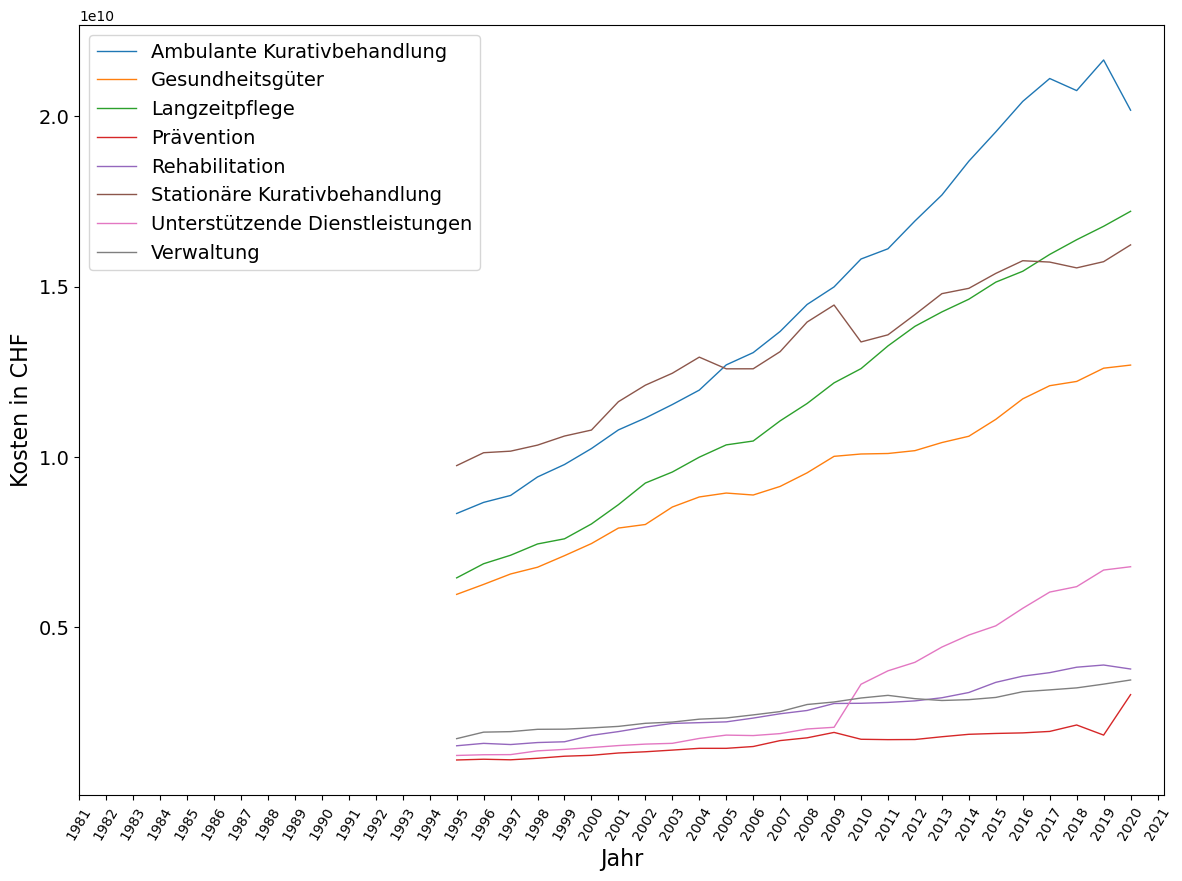

In [58]:
# setting the graph size globally
plt.rcParams['figure.figsize'] = (14, 10)

for col in df_final[["Ambulante Kurativbehandlung"
                     , "Gesundheitsgüter"
                     , "Langzeitpflege"
                     #, "LeistungenTotal"
                     , "Prävention"
                     , "Rehabilitation"
                     , "Stationäre Kurativbehandlung" 
                     , "Unterstützende Dienstleistungen"
                     , "Verwaltung"]].columns:
    plt.plot(df_final[col], linewidth=1, label=col)
    
plt.xlabel('Jahr', fontsize=16)
plt.ylabel('Kosten in CHF', fontsize=16)
default_x_ticks = range(len(df_final["Jahr"]))
plt.xticks(default_x_ticks, df_final["Jahr"], fontsize=10, rotation = 60)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.set_cmap('Paired')
plt.show()

Die grafische Darstellung zeigt, dass eine lineare Regression erfolgreich sein könnte. Bevor das versucht wird, sollen aber noch die prozentualen Anteile der Kosten der einzelnen Services an den Gesamtkosten untersucht werden. Da die Gesamtkosten für alle Jahre bekannt sind, wäre bei einem gleichmässigen Verlauf der prozentualen Anteile die Imputation sehr einfach erledigt.
  
Um die prozentualen Anteile zu berechnen, sollen nur die Kostenspalten und die Jahresspalte selektiert werden, danach wird jede der Kostenspalten verglichen mit den totalen Kosten und eine neue Spalte mit Präfix "perc_" erstellt, welche den berechneten Prozentwert beinhaltet.

In [59]:
df_costs = df_final[["Jahr"
                     , "Ambulante Kurativbehandlung"
                     , "Gesundheitsgüter"
                     , "Langzeitpflege"
                     , "LeistungenTotal"
                     , "Prävention"
                     , "Rehabilitation"
                     , "Stationäre Kurativbehandlung" 
                     , "Unterstützende Dienstleistungen"
                     , "Verwaltung"]]

df_costs = df_costs.join(df_costs.iloc[:, 1:]  \
                         .div(df_costs['LeistungenTotal'], axis=0)  \
                         .mul(100)  \
                         .add_prefix('perc_'))
df_costs.tail(10)

,Jahr,Ambulante Kurativbehandlung,Gesundheitsgüter,Langzeitpflege,LeistungenTotal,Prävention,Rehabilitation,Stationäre Kurativbehandlung,Unterstützende Dienstleistungen,Verwaltung,perc_Ambulante Kurativbehandlung,perc_Gesundheitsgüter,perc_Langzeitpflege,perc_LeistungenTotal,perc_Prävention,perc_Rehabilitation,perc_Stationäre Kurativbehandlung,perc_Unterstützende Dienstleistungen,perc_Verwaltung
31,2012,1.692449e+10,1.018146e+10,1.383165e+10,6.651243e+10,1.699660e+09,2.833700e+09,1.417631e+10,3.966270e+09,2.898900e+09,25.445605,15.307605,20.795587,100.0,2.555402,4.260407,21.313775,5.963201,4.358433
32,2013,1.768757e+10,1.041893e+10,1.425511e+10,6.911803e+10,1.780630e+09,2.925490e+09,1.479118e+10,4.414050e+09,2.845060e+09,25.590385,15.074113,20.624300,100.0,2.576216,4.232600,21.399887,6.386250,4.116234
33,2014,1.868079e+10,1.060407e+10,1.462786e+10,7.142922e+10,1.852440e+09,3.079710e+09,1.494737e+10,4.766940e+09,2.870060e+09,26.152869,14.845563,20.478818,100.0,2.593392,4.311555,20.926128,6.673655,4.018048
34,2015,1.954136e+10,1.110011e+10,1.512931e+10,7.438464e+10,1.877560e+09,3.378040e+09,1.538588e+10,5.037250e+09,2.935120e+09,26.270692,14.922583,20.339293,100.0,2.524123,4.541314,20.684217,6.771895,3.945868
35,2016,2.043638e+10,1.170209e+10,1.544866e+10,7.745521e+10,1.894010e+09,3.560310e+09,1.575800e+10,5.552550e+09,3.103200e+09,26.384771,15.108203,19.945282,100.0,2.445297,4.596605,20.344661,7.168724,4.006444
36,2017,2.110817e+10,1.208835e+10,1.594285e+10,7.964301e+10,1.937120e+09,3.662720e+09,1.571828e+10,6.028430e+09,3.157100e+09,26.503481,15.178168,20.017890,100.0,2.432254,4.598922,19.735919,7.569315,3.964064
37,2018,2.075348e+10,1.221371e+10,1.637429e+10,8.024180e+10,2.126110e+09,3.822540e+09,1.554774e+10,6.188390e+09,3.215550e+09,25.863677,15.221132,20.406185,100.0,2.649629,4.763776,19.376111,7.712177,4.007325
38,2019,2.165245e+10,1.260242e+10,1.676935e+10,8.247186e+10,1.829020e+09,3.886680e+09,1.573023e+10,6.675700e+09,3.325990e+09,26.254349,15.280873,20.333420,100.0,2.217750,4.712735,19.073451,8.094519,4.032879
39,2020,2.017776e+10,1.269354e+10,1.720926e+10,8.331076e+10,3.017500e+09,3.769680e+09,1.622316e+10,6.772730e+09,3.447120e+09,24.219873,15.236375,20.656707,100.0,3.621981,4.524842,19.473067,8.129478,4.137665
40,2021,NaN,NaN,NaN,9.103700e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN


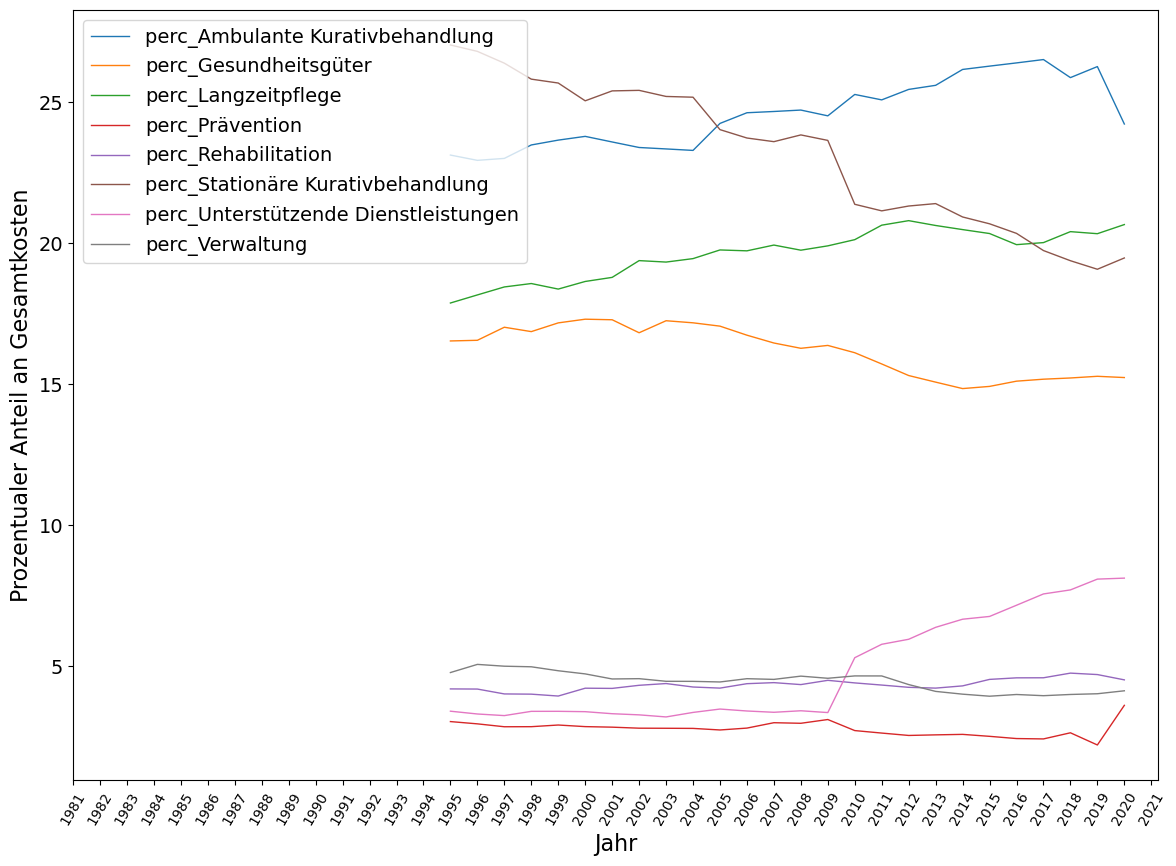

In [60]:
# setting the graph size globally
plt.rcParams['figure.figsize'] = (14, 10)

for col in df_costs[["perc_Ambulante Kurativbehandlung"
                     , "perc_Gesundheitsgüter"
                     , "perc_Langzeitpflege"
                     #, "perc_LeistungenTotal"
                     , "perc_Prävention"
                     , "perc_Rehabilitation"
                     , "perc_Stationäre Kurativbehandlung" 
                     , "perc_Unterstützende Dienstleistungen"
                     , "perc_Verwaltung"]].columns:
    plt.plot(df_costs[col], linewidth=1, label=col)
    
plt.xlabel('Jahr', fontsize=16)
plt.ylabel('Prozentualer Anteil an Gesamtkosten', fontsize=16)
default_x_ticks = range(len(df_costs["Jahr"]))
plt.xticks(default_x_ticks, df_costs["Jahr"], fontsize=10, rotation = 60)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.set_cmap('Paired')
plt.show()

Unter anderem aufgrund des Trends der Verlagerung von ambulanten zu stationären Eingriffen ist die Verteilung leider nicht sehr homogen.

In [61]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 40
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Jahr                             41 non-null     int64  
 1   0-5                              41 non-null     int64  
 2   6-10                             41 non-null     int64  
 3   11-15                            41 non-null     int64  
 4   16-20                            41 non-null     int64  
 5   21-25                            41 non-null     int64  
 6   26-30                            41 non-null     int64  
 7   31-35                            41 non-null     int64  
 8   36-40                            41 non-null     int64  
 9   41-45                            41 non-null     int64  
 10  46-50                            41 non-null     int64  
 11  51-55                            41 non-null     int64  
 12  56-60                   

##### Versuch 1: Imputation mit Linearer Regression

In [130]:
# column configuration
columns_to_impute = ["Ambulante Kurativbehandlung"
                     , "Gesundheitsgüter"
                     , "Langzeitpflege"
                     , "Prävention"
                     , "Rehabilitation"
                     , "Stationäre Kurativbehandlung" 
                     , "Unterstützende Dienstleistungen"
                     , "Verwaltung"]

# filter to get only rows with 1 or more nan values
df_to_impute  = df_final[df_final.isna().any(axis=1)]
# filter to get only rows without nan values
df_train = df_final.dropna()

# loop through the configured columns needing an imputation
for x in range(len(columns_to_impute)):
    # create linear regression
    linreg = make_pipeline(MinMaxScaler(), LinearRegression())

    # create X and y
    X = df_train[['0-5','6-10','11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50',
                 '51-55','56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96+',
                 'LIK_Gesundheitspflege','LIK_Total','LeistungenTotal']]
    y = df_train[columns_to_impute[x]]

    # split into train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # fit & predict 
    model = linreg.fit(X_train, y_train)
    predictions = linreg.predict(X_test)
    
    # print score
    print(f'Model score for {columns_to_impute[x]}:', model.score(X_test, y_test))
    # model evaluation
    print('-> mean_squared_error : ', mean_squared_error(y_test, predictions))
    print('-> mean_absolute_error : ', mean_absolute_error(y_test, predictions))


Model score for Ambulante Kurativbehandlung: 0.9800136088185508
-> mean_squared_error :  3.527929419593193e+17
-> mean_absolute_error :  426832948.9974577
Model score for Gesundheitsgüter: 0.9966986317772352
-> mean_squared_error :  1.2961322398169958e+16
-> mean_absolute_error :  99156008.2377456
Model score for Langzeitpflege: 0.9980098430329186
-> mean_squared_error :  2.072372379485249e+16
-> mean_absolute_error :  108951076.79791021
Model score for Prävention: -1.0863158253293954
-> mean_squared_error :  1.123659778567278e+17
-> mean_absolute_error :  180291661.47255126
Model score for Rehabilitation: 0.959657550363932
-> mean_squared_error :  2.1535777203946236e+16
-> mean_absolute_error :  111113085.46978395
Model score for Stationäre Kurativbehandlung: 0.9498240958221759
-> mean_squared_error :  1.565605579226563e+17
-> mean_absolute_error :  334886609.44592476
Model score for Unterstützende Dienstleistungen: 0.9846719448777354
-> mean_squared_error :  5.5957974379178856e+16
->

Das lineare Regressionsmodell liefert trotz des kleinen Datensets zwar sehr gute Resultate für die Vorhersage der Kosten aller Leistungen (Bestimmtheitsmass > 0.9), ausser bei "Prävention". Dies ist erklärbar. Die Investitionen in die Prävention sind staatlich bestimmt, nicht direkt abhängig von der Anzahl Personen pro Altersgruppe und können über die Zeit auch stark schwanken. Leider sind aber die Werte für die mittlere absolute und mittlere quadratische Abweichung astronomisch hoch. Klar sind die Basis für die Vorhersagen Milliardenwerte, aber Abweichungen von 300 Mio. und grösser sind hier nicht akzeptabel.
  
Wenn die Abweichungen nicht so gross wären, dann könnte man an dieser Stelle - da wir die Gesamtkosten für die entsprechenden Jahre kennen - die Kostenwerte für alle Leistungen ausser "Prävention" mit dem linearen Modell vorhersagen. Die Kosten für die "Prävention" sind dann pro Jahr jeweils die Gesamtkosten abzüglich der Kosten aller anderen Services. So wäre auch die Konsistenz im Datensatz gegeben (Summer der Kosten aller Einzelleistungen entspricht den Gesamtkosten).

In [123]:
# copy the dataframe
df_imputation = df_final.copy()

# filter to get only rows with 1 or more nan values
df_to_impute  = df_imputation[df_imputation.isna().any(axis=1)]
# filter to get only rows without nan values
df_train = df_imputation.dropna()

# column configuration
columns_to_impute = ["Ambulante Kurativbehandlung"
                     , "Gesundheitsgüter"
                     , "Langzeitpflege"
                     #, "Prävention" # skip this because it does not seem to be linear
                     , "Rehabilitation"
                     , "Stationäre Kurativbehandlung" 
                     , "Unterstützende Dienstleistungen"
                     , "Verwaltung"]

# loop through the configured columns needing an imputation
for x in range(len(columns_to_impute)):
    # create linear regression
    linreg = make_pipeline(MinMaxScaler(), LinearRegression())

    # create X and y
    X = df_train[['0-5','6-10','11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50',
                 '51-55','56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96+',
                 'LIK_Gesundheitspflege','LIK_Total','LeistungenTotal']]
    y = df_train[columns_to_impute[x]]

    # split into train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # fit & predict 
    model = linreg.fit(X_train, y_train)
    predictions = linreg.predict(X_test)
    
    # print for better readability
    print(f'-------------------------------------------------------------------')
    print(f'-------------------{columns_to_impute[x].upper()}-----------------')
    print(f'-------------------------------------------------------------------')

    # print score
    print(f'- Model score for {columns_to_impute[x]}:', model.score(X_test, y_test))
    
    # get predicted values for the test data set
    print(f'--- Predictions for {columns_to_impute[x]} in the test dataset:',predictions)
    
    # get predicted values for the imputation
    predictions = linreg.predict(df_imputation[['0-5','6-10','11-15','16-20',
                  '21-25','26-30','31-35','36-40','41-45','46-50','51-55','56-60','61-65','66-70',
                  '71-75','76-80','81-85','86-90','91-95','96+','LIK_Gesundheitspflege','LIK_Total',
                  'LeistungenTotal']])
    print(f'--- Predictions for {columns_to_impute[x]}. The values to be imputed are:',predictions)
    
    # impute the values
    df_imputation[str(columns_to_impute[x]+'_pred')] = predictions


-------------------------------------------------------------------
-------------------AMBULANTE KURATIVBEHANDLUNG-----------------
-------------------------------------------------------------------
- Model score for Ambulante Kurativbehandlung: 0.9939629592190635
--- Predictions for Ambulante Kurativbehandlung in the test dataset: [1.19328650e+10 1.62031129e+10 8.13598928e+09 2.13542608e+10
 1.30769038e+10 1.24890086e+10 1.47274110e+10]
--- Predictions for Ambulante Kurativbehandlung. The values to be imputed are: [1.98254462e+09 2.35640451e+09 2.86893252e+09 2.97715239e+09
 3.19590357e+09 3.62487866e+09 3.96251705e+09 4.31136860e+09
 5.09524389e+09 5.52694052e+09 6.29318082e+09 6.80863286e+09
 7.31428600e+09 7.69831010e+09 8.13598928e+09 8.55225865e+09
 8.86892270e+09 9.30425700e+09 9.71378120e+09 1.02401172e+10
 1.09513573e+10 1.14783782e+10 1.19328650e+10 1.24890086e+10
 1.28332791e+10 1.30769038e+10 1.37592542e+10 1.47274110e+10
 1.52403852e+10 1.57586243e+10 1.62031129e+10 1.680

Für Langzeitpflege, Rehabilitation und Stationäre Kurativbehandlung werden negative Werte vorhergesagt. Das kann bei einem linearen Modell natürlich immer passieren, ist aber in diesem spezifischen Fall wo es um Kosten geht nicht möglich.

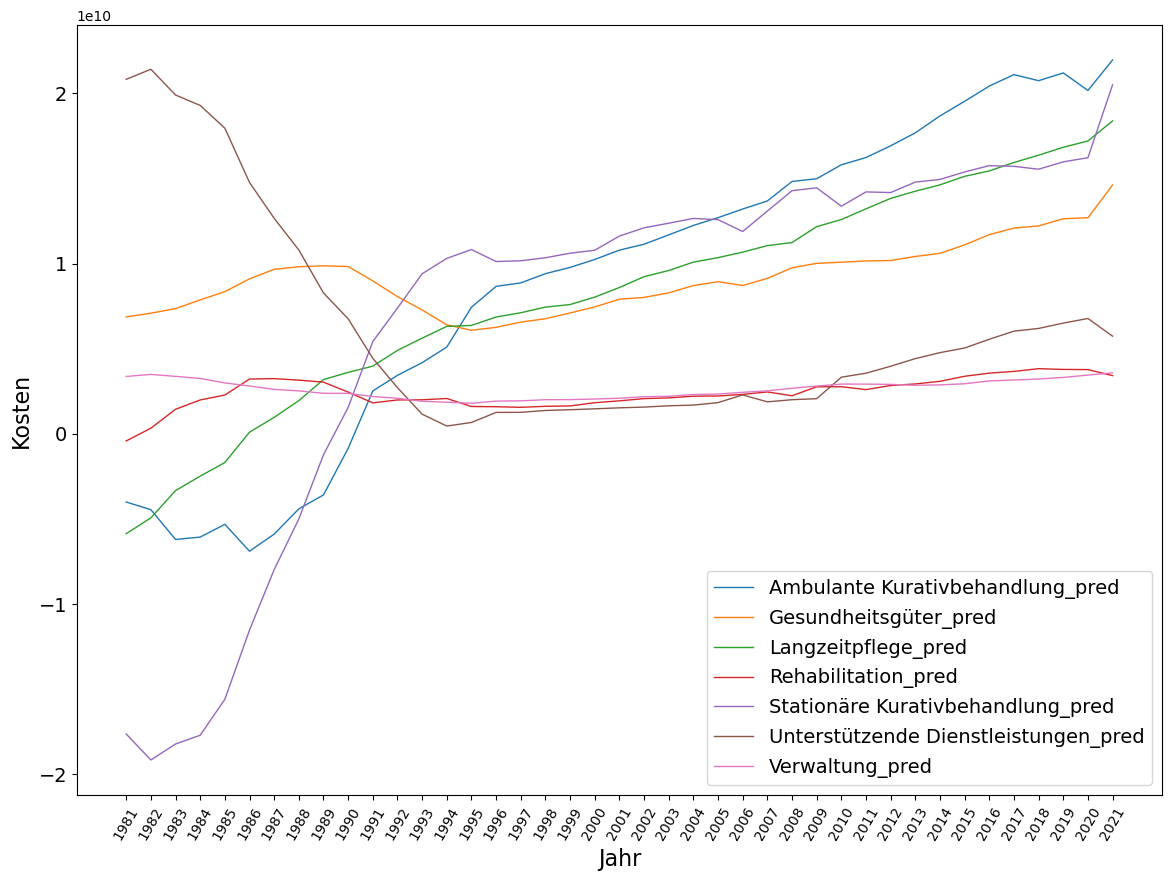

In [95]:
# setting the graph size globally
plt.rcParams['figure.figsize'] = (14, 10)

for col in df_imputation[[
                    #   "Ambulante Kurativbehandlung"
                    #, "Gesundheitsgüter"
                    #, "Langzeitpflege"
                    #, "Prävention"
                    #, "Rehabilitation"
                    #, "Stationäre Kurativbehandlung" 
                    #, "Unterstützende Dienstleistungen"
                    #, "Verwaltung"
                      "Ambulante Kurativbehandlung_pred"
                     , "Gesundheitsgüter_pred"
                     , "Langzeitpflege_pred"
                     , "Rehabilitation_pred"
                     , "Stationäre Kurativbehandlung_pred" 
                     , "Unterstützende Dienstleistungen_pred"
                     , "Verwaltung_pred"]].columns:
    plt.plot(df_imputation[col], linewidth=1, label=col)
    
plt.xlabel('Jahr', fontsize=16)
plt.ylabel('Kosten', fontsize=16)
default_x_ticks = range(len(df_imputation["Jahr"]))
plt.xticks(default_x_ticks, df_imputation["Jahr"], fontsize=10, rotation = 60)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.set_cmap('Paired')
plt.show()

Die grafische Darstellung zeigt, dass bei den Vorhersagen etwas nicht stimmen kann. Es soll also ein anderer Approach für die Imputation der fehlenden Werte gefunden werden.

##### Versuch 2: Imputation mit sklearn IterativeImputer

TODO: Erklärung was IterativeImputer macht

In [140]:
# copy the dataframe
df_imputation = df_final.copy()

# Setting the random_state argument for reproducibility
imputer = IterativeImputer(random_state = 42, 
                           skip_complete = True,
                           sample_posterior = True, 
                           max_iter = 20, 
                           missing_values = np.nan, 
                           min_value = 0)
imputed = imputer.fit_transform(df_imputation)
df_imputed = pd.DataFrame(imputed, columns=df_imputation.columns)

df_imputed['LeistungenTotalSum'] = df_imputed['Gesundheitsgüter'] + df_imputed['Langzeitpflege'] +  \
                            df_imputed['Ambulante Kurativbehandlung'] + df_imputed['Rehabilitation'] +  \
                            df_imputed['Stationäre Kurativbehandlung'] + df_imputed['Verwaltung'] +  \
                            df_imputed['Unterstützende Dienstleistungen']+ df_imputed['Prävention']

df_imputed[['Jahr','Ambulante Kurativbehandlung','Stationäre Kurativbehandlung','Langzeitpflege',
           'Rehabilitation','Gesundheitsgüter','Verwaltung','Prävention','Unterstützende Dienstleistungen',
           'LeistungenTotal','LeistungenTotalSum']]



,Jahr,Ambulante Kurativbehandlung,Stationäre Kurativbehandlung,Langzeitpflege,Rehabilitation,Gesundheitsgüter,Verwaltung,Prävention,Unterstützende Dienstleistungen,LeistungenTotal,LeistungenTotalSum
0,1981.0,2.577671e+09,8.555970e+09,1.679541e+06,6.490911e+08,1.096517e+07,0.000000e+00,4.669370e+06,3.090938e+09,1.489146e+10,1.489098e+10
1,1982.0,2.574063e+09,9.803278e+09,1.138600e+06,6.226687e+08,4.742125e+06,0.000000e+00,2.750108e+05,3.091270e+09,1.609838e+10,1.609743e+10
2,1983.0,2.568803e+09,1.049319e+10,2.258607e+06,1.272352e+09,7.755338e+06,0.000000e+00,3.211602e+06,3.105360e+09,1.745264e+10,1.745293e+10
3,1984.0,2.573064e+09,1.228856e+10,0.000000e+00,1.029844e+08,4.776567e+06,0.000000e+00,4.110636e+06,3.089573e+09,1.806129e+10,1.806306e+10
4,1985.0,2.569957e+09,1.326747e+10,1.916265e+05,8.707583e+07,7.187720e+06,0.000000e+00,5.107488e+06,3.097627e+09,1.903567e+10,1.903462e+10
5,1986.0,2.578711e+09,1.432837e+10,0.000000e+00,4.106296e+08,1.191511e+06,0.000000e+00,4.206069e+06,3.085932e+09,2.040907e+10,2.040904e+10
6,1987.0,2.574296e+09,1.532479e+10,1.562885e+06,4.254629e+08,7.597869e+06,0.000000e+00,2.454302e+08,3.091984e+09,2.167245e+10,2.167112e+10
7,1988.0,2.575685e+09,1.532230e+10,1.038268e+08,4.391140e+08,1.808985e+06,0.000000e+00,1.615382e+09,3.087407e+09,2.314573e+10,2.314552e+10
8,1989.0,2.572908e+09,1.433338e+10,1.984157e+09,1.421602e+09,5.564523e+06,0.000000e+00,1.616969e+09,3.090701e+09,2.502570e+10,2.502528e+10
9,1990.0,2.572843e+09,1.538612e+10,3.895319e+09,3.589849e+08,4.508500e+06,0.000000e+00,1.628208e+09,3.091427e+09,2.693573e+10,2.693741e+10


Interessanterweise stimmt die aus den resultierenden Werten der Imputation errechnete Summe sehr genau mit den effektiven Gesamtkosten überein. Bei näherer Betrachtung sieht man aber, dass z.B. für die "Verwaltung" plötzlich nur noch Kosten von 0 CHF vorhergesagt wurden. Dies liegt an der Konfiguration des minimalen Wertes von "0" im Modell (Option "min_value"). Wenn diese entfernt wird, werden aber wieder negative Werte vorhergesagt, was im Fall von Kosten wie bereits bei der linearen Regression beschrieben keinen Sinn macht.
  
Grafisch sieht das Ganze wie folgt aus:

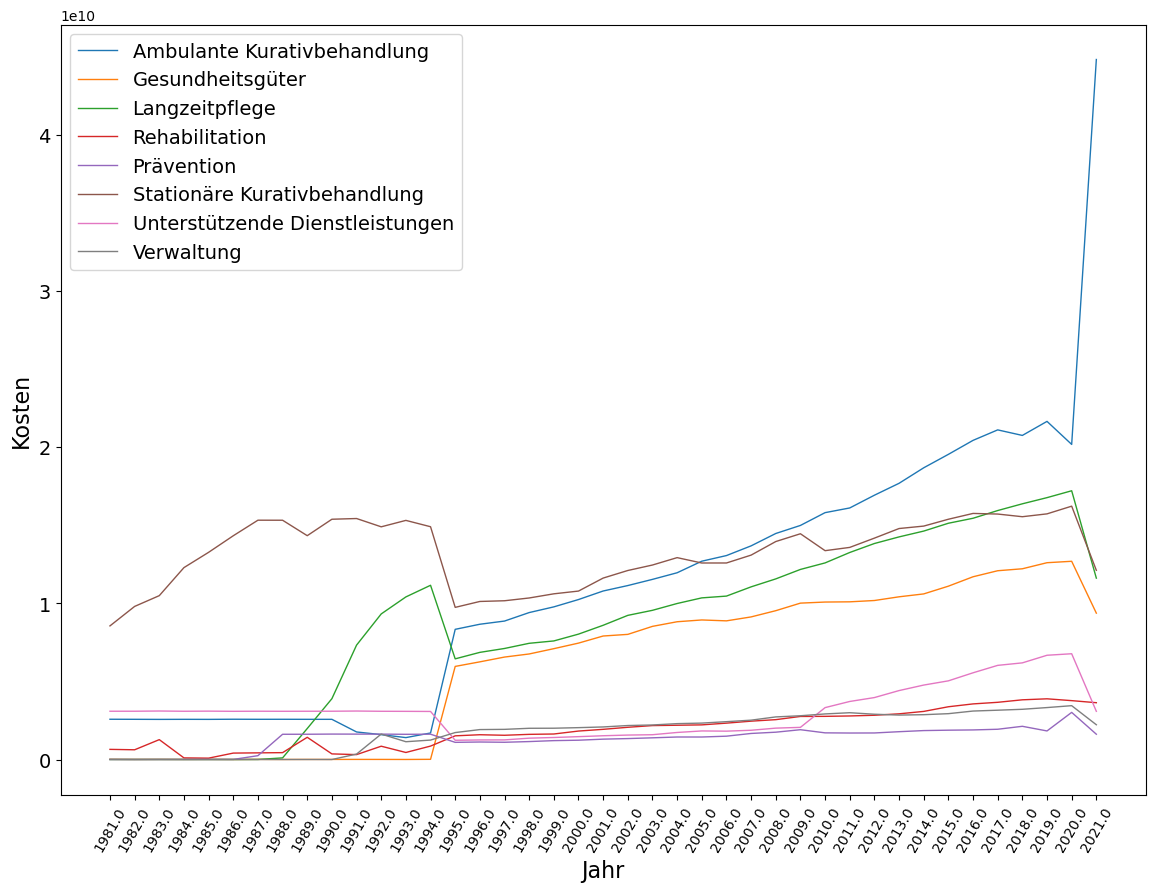

In [141]:
# setting the graph size globally
plt.rcParams['figure.figsize'] = (14, 10)

for col in df_imputed[[
                      "Ambulante Kurativbehandlung"
                     , "Gesundheitsgüter"
                     , "Langzeitpflege"
                     , "Rehabilitation"
                     , "Prävention"
                     , "Stationäre Kurativbehandlung" 
                     , "Unterstützende Dienstleistungen"
                     , "Verwaltung"]].columns:
    plt.plot(df_imputed[col], linewidth=1, label=col)
    
plt.xlabel('Jahr', fontsize=16)
plt.ylabel('Kosten', fontsize=16)
default_x_ticks = range(len(df_imputed["Jahr"]))
plt.xticks(default_x_ticks, df_imputed["Jahr"], fontsize=10, rotation = 60)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.set_cmap('Paired')
plt.show()

Die Vorhersagen sehen zwar grösstenteils ein bisschen realistischer aus als bei der linearen Regression, aber zufriedenstellend ist dies noch nicht.

##### Versuch 3: Imputation anhand prozentualer Anteile aus letztem verfügbarem Jahr und den Gesamtkosten

Die fehlenden Werte sollen in diesem Versuch wie folgt errechnet werden:
* 1981-1994: prozentuale Anteile aus dem Jahr 1995 nehmen und die Gesamtkosten von 1981-1994 jeweils pro Jahr entsprechend aufteilen
* 2021: prozentuale Anteile aus dem Jahr 2020 nehmen und die Gesamtkosten von 2021 entsprechend aufteilen

In [176]:
# copy the dataframe
df_imputation = df_final.copy()

# column configuration
columns_to_impute = ["Ambulante Kurativbehandlung"
                     , "Gesundheitsgüter"
                     , "Langzeitpflege"
                     , "Prävention"
                     , "Rehabilitation"
                     , "Stationäre Kurativbehandlung" 
                     , "Unterstützende Dienstleistungen"
                     , "Verwaltung"
                     , "LeistungenTotal"]

# get percentages from 1995
percentages = df_imputation.iloc[14, 21:30] / df_imputation.loc[14,'LeistungenTotal']

# loop through rows 0-13 (1981-1994)
for index, row in df_imputation.iloc[0:14, :].iterrows():
    # loop through the configured columns needing an imputation
    for x in range(len(columns_to_impute)):   
        df_imputation.at[index,columns_to_impute[x]] = row['LeistungenTotal'] * percentages[columns_to_impute[x]]

# get percentages from 2020
percentages = df_imputation.iloc[39, 21:30] / df_imputation.loc[39,'LeistungenTotal']

# loop through rows 40-? (2021)
for index, row in df_imputation.iloc[40:, :].iterrows():
    # loop through the configured columns needing an imputation
    for x in range(len(columns_to_impute)):   
        df_imputation.at[index,columns_to_impute[x]] = row['LeistungenTotal'] * percentages[columns_to_impute[x]]


In [177]:
df_imputation

,Jahr,0-5,6-10,11-15,16-20,21-25,26-30,31-35,36-40,41-45,...,Gesundheitsgüter,Langzeitpflege,LeistungenTotal,Prävention,Rehabilitation,Stationäre Kurativbehandlung,Unterstützende Dienstleistungen,Verwaltung,LIK_Gesundheitspflege,LIK_Total
0,1981,431325,400210,480991,514235,473002,467278,505158,481168,408917,...,2.462011e+09,2.662223e+09,1.489146e+10,4.537193e+08,6.260787e+08,4.023666e+09,5.085003e+08,7.124422e+08,6.10,6.5
1,1982,434149,385327,467927,521430,482250,473392,497973,495610,417029,...,2.661551e+09,2.877991e+09,1.609838e+10,4.904922e+08,6.768210e+08,4.349775e+09,5.497131e+08,7.701841e+08,5.35,5.7
2,1983,434990,374360,452977,519470,489770,477680,492391,503010,430974,...,2.885452e+09,3.120099e+09,1.745264e+10,5.317544e+08,7.337579e+08,4.715696e+09,5.959571e+08,8.349751e+08,2.60,2.9
3,1984,437710,366189,436142,514525,501910,484155,486492,508266,446156,...,2.986080e+09,3.228910e+09,1.806129e+10,5.502990e+08,7.593472e+08,4.880153e+09,6.167408e+08,8.640943e+08,3.20,2.9
4,1985,440312,361992,420592,503340,515064,491542,485001,508180,462516,...,3.147175e+09,3.403105e+09,1.903567e+10,5.799868e+08,8.003129e+08,5.143430e+09,6.500130e+08,9.107109e+08,4.00,3.4
5,1986,442945,364423,405294,492157,525702,499457,486409,508789,478296,...,3.374239e+09,3.648635e+09,2.040907e+10,6.218321e+08,8.580545e+08,5.514522e+09,6.969107e+08,9.764176e+08,2.20,0.8
6,1987,446957,367747,391767,479894,533533,509132,493856,503200,492713,...,3.583114e+09,3.874496e+09,2.167245e+10,6.603253e+08,9.111705e+08,5.855887e+09,7.400514e+08,1.036861e+09,2.70,1.4
7,1988,453859,372491,384007,466933,534402,520417,502444,501702,502162,...,3.826692e+09,4.137882e+09,2.314573e+10,7.052138e+08,9.731114e+08,6.253966e+09,7.903597e+08,1.107346e+09,3.60,1.9
8,1989,461401,377307,379417,452564,530680,535274,512663,498833,508713,...,4.137508e+09,4.473974e+09,2.502570e+10,7.624935e+08,1.052151e+09,6.761933e+09,8.545552e+08,1.197288e+09,1.90,3.2
9,1990,474178,384891,379637,441034,524237,555156,525618,501367,511180,...,4.453294e+09,4.815440e+09,2.693573e+10,8.206891e+08,1.132454e+09,7.278022e+09,9.197772e+08,1.288668e+09,4.10,5.4


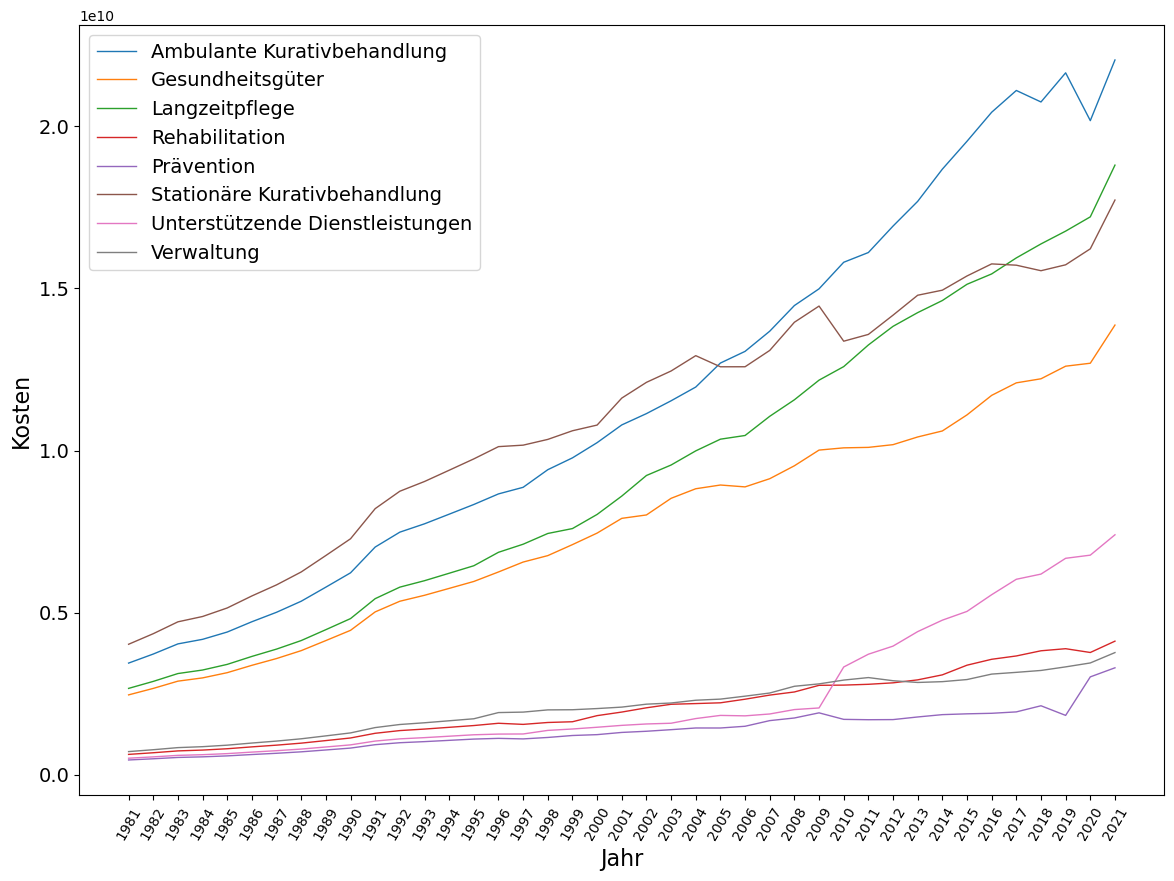

In [179]:
# setting the graph size globally
plt.rcParams['figure.figsize'] = (14, 10)

for col in df_imputation[[
                      "Ambulante Kurativbehandlung"
                     , "Gesundheitsgüter"
                     , "Langzeitpflege"
                     , "Rehabilitation"
                     , "Prävention"
                     , "Stationäre Kurativbehandlung" 
                     , "Unterstützende Dienstleistungen"
                     , "Verwaltung"]].columns:
    plt.plot(df_imputation[col], linewidth=1, label=col)
    
plt.xlabel('Jahr', fontsize=16)
plt.ylabel('Kosten', fontsize=16)
default_x_ticks = range(len(df_imputation["Jahr"]))
plt.xticks(default_x_ticks, df_imputation["Jahr"], fontsize=10, rotation = 60)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.set_cmap('Paired')
plt.show()